<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL/blob/master/FinRL_ensemble_stock_trading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
# !pip3 install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [2]:
import sys
sys.path

['/Users/evienguyen/Documents/FinRL/FinRL',
 '/usr/local/Cellar/python@3.9/3.9.1_6/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/usr/local/Cellar/python@3.9/3.9.1_6/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/usr/local/Cellar/python@3.9/3.9.1_6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/evienguyen/Library/Python/3.9/lib/python/site-packages',
 '/usr/local/lib/python3.9/site-packages',
 '/Users/evienguyen/Library/Python/3.9/lib/python/site-packages/IPython/extensions',
 '/Users/evienguyen/.ipython']

In [3]:
# ensemble_agent.print_test()
import os
os.chdir('/Users/evienguyen/Documents/FinRL/FinRL/finrl')
os.getcwd()

'/Users/evienguyen/Documents/FinRL/FinRL/finrl'


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [6]:
 print (dir(DRLEnsembleAgent))

['DRL_prediction', 'DRL_validation', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'get_model', 'get_validation_sharpe', 'print_test', 'run_ensemble_strategy', 'train_model']


<a id='1.4'></a>
## 2.4. Create Folders

In [7]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [8]:
import sys
sys.path.append("../Users/evienguyen/Documents/FinRL/FinRL/finrl")

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [9]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [10]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [11]:
df = YahooDownloader(start_date = '2010-01-01',
                     end_date = '2021-06-14',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.572422,493729600.0,AAPL,0
1,2010-01-04,40.810001,41.099998,40.389999,34.405621,6894300.0,AXP,0
2,2010-01-04,55.720001,56.389999,54.799999,43.777542,6186700.0,BA,0
3,2010-01-04,57.650002,59.189999,57.509998,42.787361,7325600.0,CAT,0
4,2010-01-04,24.110001,24.840000,24.010000,18.332541,59853700.0,CSCO,0


In [13]:
df.tail()

,date,open,high,low,close,volume,tic,day
86395,2021-06-11,234.389999,235.440002,233.710007,234.960007,5376500.0,V,4
86396,2021-06-11,57.490002,57.549999,57.009998,57.330002,12924100.0,VZ,4
86397,2021-06-11,55.580002,55.820000,54.810001,55.310001,3942600.0,WBA,4
86398,2021-06-11,140.229996,140.850006,139.860001,140.750000,8408800.0,WMT,4
86399,2021-06-11,63.009998,63.189999,62.139999,62.169998,17618900.0,XOM,4


In [14]:
df.shape

(86400, 8)

In [15]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.572422,493729600.0,AAPL,0
1,2010-01-04,40.810001,41.099998,40.389999,34.405621,6894300.0,AXP,0
2,2010-01-04,55.720001,56.389999,54.799999,43.777542,6186700.0,BA,0
3,2010-01-04,57.650002,59.189999,57.509998,42.787361,7325600.0,CAT,0
4,2010-01-04,24.110001,24.840000,24.010000,18.332541,59853700.0,CSCO,0


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [16]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [17]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [18]:
processed_full.sample(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
72724,2016-08-24,CSCO,30.980000,31.200001,30.950001,26.729086,24474700.0,2.0,0.215539,26.894651,26.140128,61.509439,100.043110,16.482140,26.391747,25.514014,9.208442
15567,2011-06-06,WBA,43.009998,43.470001,42.939999,33.225731,5803800.0,0.0,0.120316,34.937304,33.013365,52.158286,-35.764926,25.048593,33.623655,32.613913,18.143360
50119,2014-08-01,NKE,38.270000,38.625000,38.195000,35.548630,5825800.0,4.0,0.146177,36.713782,35.250203,50.603858,-52.915138,0.714373,35.845718,35.294847,58.146455
80902,2017-05-23,RTX,76.563873,77.079926,76.544998,69.725555,5409433.0,1.0,0.984325,69.911118,67.111163,68.935131,93.177054,23.993901,67.248936,65.553472,13.999506
99215,2019-01-24,CVX,111.029999,113.820000,110.910004,100.559296,8470700.0,3.0,0.149488,101.979245,95.252855,50.299419,46.490710,2.568560,98.258585,100.398791,40.398194


<AxesSubplot:xlabel='date'>

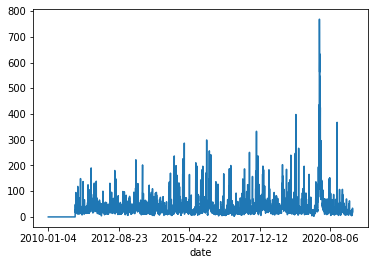

In [19]:
processed_full_copy = processed_full
processed_full_copy.set_index('date',inplace=True)
%matplotlib inline
processed_full_copy.turbulence.plot()


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [20]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 301


In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [23]:
processed_full.reset_index(inplace=True)

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [24]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2010-01-01'
train_end = '2016-10-01'
val_test_start = '2016-10-01'
val_test_end = '2021-06-14'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [25]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }

In [26]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
16.887756699950526
turbulence_threshold:  299.0428503713953
======Model training from:  2010-01-01 to  2016-10-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_7
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.302    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -95.9    |
|    std                | 1        |
|    value_loss         | 4.89     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 149      |
|    iterations         | 200

-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.69e+06  |
|    total_cost         | 4.07e+04  |
|    total_reward       | 6.86e+05  |
|    total_reward_pct   | 68.6      |
|    total_trades       | 34375     |
| time/                 |           |
|    fps                | 149       |
|    iterations         | 1400      |
|    time_elapsed       | 46        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -43.1     |
|    explained_variance | -8.34e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1399      |
|    policy_loss        | 36.3      |
|    std                | 1.02      |
|    value_loss         | 0.744     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 1500     |
|    time_elapsed       | 49       |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 151      |
|    iterations         | 2700     |
|    time_elapsed       | 88       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 26.8     |
|    std                | 1.03     |
|    value_loss         | 1.11     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.52e+06 |
|    total_cost         | 2.71e+04 |
|    total_reward       | 5.18e+05 |
|    total_reward_pct   | 51.8     |
|    total_trades       | 33136    |
| time/                 |          |
|    fps                | 152      |
|    iterations         | 2800     |
|    time_elapsed       | 92       |
|    total_timesteps    | 14000    |
|

------------------------------------
| time/                 |          |
|    fps                | 152      |
|    iterations         | 4000     |
|    time_elapsed       | 131      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3999     |
|    policy_loss        | -64.2    |
|    std                | 1.03     |
|    value_loss         | 3.85     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.53e+06 |
|    total_cost         | 1.82e+04 |
|    total_reward       | 5.31e+05 |
|    total_reward_pct   | 53.1     |
|    total_trades       | 30300    |
| time/                 |          |
|    fps                | 152      |
|    iterations         | 4100     |
|    time_elapsed       | 134      |
|    total_timesteps    | 20500    |
|

------------------------------------
| time/                 |          |
|    fps                | 152      |
|    iterations         | 5300     |
|    time_elapsed       | 173      |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -43.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5299     |
|    policy_loss        | -50.1    |
|    std                | 1.05     |
|    value_loss         | 2.04     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 152      |
|    iterations         | 5400     |
|    time_elapsed       | 176      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -43.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5399     |
|    policy_loss        | -169     |
|

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.81e+06   |
|    total_cost           | 1.62e+05   |
|    total_reward         | 8.11e+05   |
|    total_reward_pct     | 81.1       |
|    total_trades         | 48795      |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 5          |
|    time_elapsed         | 63         |
|    total_timesteps      | 10240      |
| train/                  |            |
|    approx_kl            | 0.01957041 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.8      |
|    explained_variance   | -0.00989   |
|    learning_rate        | 0.00025    |
|    loss                 | 3.29       |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0272    |
|    std                  | 1.01       |
|    value_loss           | 8.45       |
----------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.96e+06   |
|    total_cost           | 1.5e+05    |
|    total_reward         | 9.64e+05   |
|    total_reward_pct     | 96.4       |
|    total_trades         | 47539      |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 13         |
|    time_elapsed         | 167        |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.01741739 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.3      |
|    explained_variance   | 0.0275     |
|    learning_rate        | 0.00025    |
|    loss                 | 4.3        |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.0201    |
|    std                  | 1.02       |
|    value_loss           | 8.53       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.76e+06    |
|    total_cost           | 1.51e+05    |
|    total_reward         | 7.55e+05    |
|    total_reward_pct     | 75.5        |
|    total_trades         | 47744       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 21          |
|    time_elapsed         | 270         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.022178732 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.5         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1.04        |
|    value_loss           | 10.5  

---------------------------------------
| environment/            |           |
|    portfolio_value      | 1.84e+06  |
|    total_cost           | 1.36e+05  |
|    total_reward         | 8.38e+05  |
|    total_reward_pct     | 83.8      |
|    total_trades         | 46522     |
| time/                   |           |
|    fps                  | 159       |
|    iterations           | 29        |
|    time_elapsed         | 372       |
|    total_timesteps      | 59392     |
| train/                  |           |
|    approx_kl            | 0.0350829 |
|    clip_fraction        | 0.268     |
|    clip_range           | 0.2       |
|    entropy_loss         | -44       |
|    explained_variance   | 0.13      |
|    learning_rate        | 0.00025   |
|    loss                 | 4.01      |
|    n_updates            | 280       |
|    policy_gradient_loss | -0.0178   |
|    std                  | 1.05      |
|    value_loss           | 10.3      |
---------------------------------------


-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.68e+06    |
|    total_cost           | 1.38e+05    |
|    total_reward         | 6.76e+05    |
|    total_reward_pct     | 67.6        |
|    total_trades         | 46539       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 37          |
|    time_elapsed         | 475         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.030729316 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.5       |
|    explained_variance   | 0.174       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.63        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.021      |
|    std                  | 1.07        |
|    value_loss           | 7.18  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.99e+06    |
|    total_cost           | 1.38e+05    |
|    total_reward         | 9.94e+05    |
|    total_reward_pct     | 99.4        |
|    total_trades         | 46627       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 45          |
|    time_elapsed         | 579         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.053507574 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45         |
|    explained_variance   | 0.114       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.56        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0167     |
|    std                  | 1.09        |
|    value_loss           | 10.5  

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.47e+06 |
|    total_cost         | 1.04e+05 |
|    total_reward       | 1.47e+06 |
|    total_reward_pct   | 147      |
|    total_trades       | 43714    |
| time/                 |          |
|    fps                | 137      |
|    iterations         | 400      |
|    time_elapsed       | 14       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.44    |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | 23.6     |
|    std                | 1.01     |
|    value_loss         | 2.52     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 500      |
|    time_elapsed       | 17       |
|    total_timesteps    | 2500     |
|

day: 1761, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1636310.95
total_reward: 636310.95
total_cost: 21968.73
total_trades: 31223
Sharpe: 0.485
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.64e+06 |
|    total_cost         | 2.2e+04  |
|    total_reward       | 6.36e+05 |
|    total_reward_pct   | 63.6     |
|    total_trades       | 31223    |
| time/                 |          |
|    fps                | 139      |
|    iterations         | 1800     |
|    time_elapsed       | 64       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0.419    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1799     |
|    policy_loss        | 40.5     |
|    std                | 1.02     |
|    value_loss         | 0.952    |
------------------------------------
------------------------------------
| time/                 |  

------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 3100     |
|    time_elapsed       | 110      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3099     |
|    policy_loss        | -143     |
|    std                | 1.02     |
|    value_loss         | 11.2     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.74e+06  |
|    total_cost         | 2.36e+04  |
|    total_reward       | 7.38e+05  |
|    total_reward_pct   | 73.8      |
|    total_trades       | 32997     |
| time/                 |           |
|    fps                | 140       |
|    iterations         | 3200      |
|    time_elapsed       | 113       |
|    total_timesteps    | 1

------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 4400     |
|    time_elapsed       | 154      |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4399     |
|    policy_loss        | 19       |
|    std                | 1.03     |
|    value_loss         | 1.06     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 4500     |
|    time_elapsed       | 157      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4499     |
|    policy_loss        | -11.8    |
|

------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 5800     |
|    time_elapsed       | 201      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | 29.9     |
|    std                | 1.04     |
|    value_loss         | 0.512    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 5900     |
|    time_elapsed       | 205      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | -184     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.45e+06 |
|    total_cost         | 8.22e+04 |
|    total_reward       | 4.53e+05 |
|    total_reward_pct   | 45.3     |
|    total_trades       | 40958    |
| time/                 |          |
|    fps                | 141      |
|    iterations         | 1100     |
|    time_elapsed       | 38       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.00844 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1099     |
|    policy_loss        | 20.5     |
|    std                | 1        |
|    value_loss         | 0.365    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 1200     |
|    time_elapsed       | 42       |
|    total_timesteps    | 6000     |
|

------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 2400     |
|    time_elapsed       | 84       |
|    total_timesteps    | 12000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.0125  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2399     |
|    policy_loss        | 149      |
|    std                | 1.01     |
|    value_loss         | 25.6     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.99e+06 |
|    total_cost         | 5.63e+04 |
|    total_reward       | 9.9e+05  |
|    total_reward_pct   | 99       |
|    total_trades       | 35534    |
| time/                 |          |
|    fps                | 142      |
|    iterations         | 2500     |
|    time_elapsed       | 87       |
|    total_timesteps    | 12500    |
|

------------------------------------
| time/                 |          |
|    fps                | 145      |
|    iterations         | 3700     |
|    time_elapsed       | 126      |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3699     |
|    policy_loss        | 52.5     |
|    std                | 1.02     |
|    value_loss         | 4.08     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 146      |
|    iterations         | 3800     |
|    time_elapsed       | 130      |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | -0.55    |
|    learning_rate      | 0.0005   |
|    n_updates          | 3799     |
|    policy_loss        | 65.6     |
|

------------------------------------
| time/                 |          |
|    fps                | 148      |
|    iterations         | 5100     |
|    time_elapsed       | 171      |
|    total_timesteps    | 25500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.0165   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5099     |
|    policy_loss        | -119     |
|    std                | 1.02     |
|    value_loss         | 11.3     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 148      |
|    iterations         | 5200     |
|    time_elapsed       | 175      |
|    total_timesteps    | 26000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5199     |
|    policy_loss        | 43       |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.2e+06     |
|    total_cost           | 1.71e+05    |
|    total_reward         | 1.2e+06     |
|    total_reward_pct     | 120         |
|    total_trades         | 50578       |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 3           |
|    time_elapsed         | 38          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.016683226 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.0255     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.29        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0225     |
|    std                  | 1.01        |
|    value_loss           | 9.88  

day: 1761, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1773484.83
total_reward: 773484.83
total_cost: 162985.98
total_trades: 49602
Sharpe: 0.676
----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.77e+06   |
|    total_cost           | 1.63e+05   |
|    total_reward         | 7.73e+05   |
|    total_reward_pct     | 77.3       |
|    total_trades         | 49602      |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 11         |
|    time_elapsed         | 140        |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.03571555 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.1      |
|    explained_variance   | 0.0232     |
|    learning_rate        | 0.00025    |
|    loss                 | 3.74       |
|    n_updates     

day: 1761, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 2004975.60
total_reward: 1004975.60
total_cost: 152527.87
total_trades: 48915
Sharpe: 0.799
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2e+06       |
|    total_cost           | 1.53e+05    |
|    total_reward         | 1e+06       |
|    total_reward_pct     | 100         |
|    total_trades         | 48915       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 19          |
|    time_elapsed         | 242         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.028465418 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0411      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.2         

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.08e+06    |
|    total_cost           | 1.6e+05     |
|    total_reward         | 1.08e+06    |
|    total_reward_pct     | 108         |
|    total_trades         | 49266       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 27          |
|    time_elapsed         | 344         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.026809718 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.7       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.85        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0167     |
|    std                  | 1.04        |
|    value_loss           | 8.34  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.68e+06   |
|    total_cost           | 1.46e+05   |
|    total_reward         | 6.78e+05   |
|    total_reward_pct     | 67.8       |
|    total_trades         | 48043      |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 35         |
|    time_elapsed         | 445        |
|    total_timesteps      | 71680      |
| train/                  |            |
|    approx_kl            | 0.04184514 |
|    clip_fraction        | 0.346      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.1      |
|    explained_variance   | 0.103      |
|    learning_rate        | 0.00025    |
|    loss                 | 2.35       |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0183    |
|    std                  | 1.05       |
|    value_loss           | 7.12       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.48e+06    |
|    total_cost           | 1.44e+05    |
|    total_reward         | 4.81e+05    |
|    total_reward_pct     | 48.1        |
|    total_trades         | 47685       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 43          |
|    time_elapsed         | 547         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.030711543 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.0817      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.66        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0243     |
|    std                  | 1.07        |
|    value_loss           | 9.89  

day: 1761, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 2141539.10
total_reward: 1141539.10
total_cost: 1290.30
total_trades: 28196
Sharpe: 0.792
======DDPG Validation from:  2017-01-03 to  2017-04-04
======Best Model Retraining from:  2010-01-01 to  2017-04-04
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ensemble_189_2
----------------------------------
| environment/        |          |
|    portfolio_value  | 1.99e+06 |
|    total_cost       | 1.79e+05 |
|    total_reward     | 9.87e+05 |
|    total_reward_pct | 98.7     |
|    total_trades     | 52590    |
| time/               |          |
|    fps              | 164      |
|    iterations       | 1        |
|    time_elapsed     | 12       |
|    total_timesteps  | 2048     |
----------------------------------
---------------------------------------
| environment/            |           |
|    portfolio_value      | 2.19e+06  |
|    

day: 1824, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2236812.61
total_reward: 1236812.61
total_cost: 166429.06
total_trades: 51196
Sharpe: 0.798
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.24e+06    |
|    total_cost           | 1.66e+05    |
|    total_reward         | 1.24e+06    |
|    total_reward_pct     | 124         |
|    total_trades         | 51196       |
| time/                   |             |
|    fps                  | 156         |
|    iterations           | 9           |
|    time_elapsed         | 117         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.025306644 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | -0.000481   |
|    learning_rate        | 0.00025     |
|    loss                 | 3.74        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.63e+06    |
|    total_cost           | 1.74e+05    |
|    total_reward         | 1.63e+06    |
|    total_reward_pct     | 163         |
|    total_trades         | 51246       |
| time/                   |             |
|    fps                  | 156         |
|    iterations           | 17          |
|    time_elapsed         | 222         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.018865863 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0647      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.42        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0187     |
|    std                  | 1.02        |
|    value_loss           | 10.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.45e+06    |
|    total_cost           | 1.64e+05    |
|    total_reward         | 1.45e+06    |
|    total_reward_pct     | 145         |
|    total_trades         | 50494       |
| time/                   |             |
|    fps                  | 156         |
|    iterations           | 25          |
|    time_elapsed         | 327         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.020944906 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0176      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.72        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0201     |
|    std                  | 1.03        |
|    value_loss           | 14.4  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.54e+06   |
|    total_cost           | 1.62e+05   |
|    total_reward         | 1.54e+06   |
|    total_reward_pct     | 154        |
|    total_trades         | 50290      |
| time/                   |            |
|    fps                  | 155        |
|    iterations           | 33         |
|    time_elapsed         | 434        |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.02079864 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.0337     |
|    learning_rate        | 0.00025    |
|    loss                 | 8.53       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0186    |
|    std                  | 1.05       |
|    value_loss           | 16.1       |
----------------

day: 1824, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 2118596.20
total_reward: 1118596.20
total_cost: 159336.23
total_trades: 50236
Sharpe: 0.754
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.59e+06    |
|    total_cost           | 1.59e+05    |
|    total_reward         | 1.59e+06    |
|    total_reward_pct     | 159         |
|    total_trades         | 49981       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 41          |
|    time_elapsed         | 546         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.024828456 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.0712      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.28        

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.24e+06   |
|    total_cost           | 1.51e+05   |
|    total_reward         | 1.24e+06   |
|    total_reward_pct     | 124        |
|    total_trades         | 49037      |
| time/                   |            |
|    fps                  | 153        |
|    iterations           | 49         |
|    time_elapsed         | 654        |
|    total_timesteps      | 100352     |
| train/                  |            |
|    approx_kl            | 0.03991959 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.8      |
|    explained_variance   | -0.016     |
|    learning_rate        | 0.00025    |
|    loss                 | 5.27       |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0192    |
|    std                  | 1.08       |
|    value_loss           | 16.2       |
----------------

------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 1300     |
|    time_elapsed       | 43       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1299     |
|    policy_loss        | -102     |
|    std                | 1.01     |
|    value_loss         | 6.57     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 1400     |
|    time_elapsed       | 46       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | -17.3    |
|

------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 2700     |
|    time_elapsed       | 89       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -0.0781  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | -106     |
|    std                | 1.01     |
|    value_loss         | 11       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 2800     |
|    time_elapsed       | 92       |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | -0.0171  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss        | 63.5     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.84e+06 |
|    total_cost         | 7.09e+04 |
|    total_reward       | 8.37e+05 |
|    total_reward_pct   | 83.7     |
|    total_trades       | 38941    |
| time/                 |          |
|    fps                | 150      |
|    iterations         | 4100     |
|    time_elapsed       | 135      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.029    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | -3.52    |
|    std                | 1.02     |
|    value_loss         | 2.1      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 4200     |
|    time_elapsed       | 139      |
|    total_timesteps    | 21000    |
|

day: 1824, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 1953323.61
total_reward: 953323.61
total_cost: 53644.10
total_trades: 34530
Sharpe: 0.711
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.95e+06 |
|    total_cost         | 5.36e+04 |
|    total_reward       | 9.53e+05 |
|    total_reward_pct   | 95.3     |
|    total_trades       | 34530    |
| time/                 |          |
|    fps                | 151      |
|    iterations         | 5500     |
|    time_elapsed       | 182      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | -0.228   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss        | -89      |
|    std                | 1.03     |
|    value_loss         | 5.73     |
------------------------------------
------------------------------------
| time/                 | 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.68e+06    |
|    total_cost           | 1.7e+05     |
|    total_reward         | 6.81e+05    |
|    total_reward_pct     | 68.1        |
|    total_trades         | 51832       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 6           |
|    time_elapsed         | 77          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.020000678 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.0239      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.65        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0302     |
|    std                  | 1.01        |
|    value_loss           | 12.5  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.91e+06    |
|    total_cost           | 1.72e+05    |
|    total_reward         | 9.05e+05    |
|    total_reward_pct     | 90.5        |
|    total_trades         | 51722       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 14          |
|    time_elapsed         | 193         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.038715065 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0525      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.18        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0208     |
|    std                  | 1.02        |
|    value_loss           | 7.74  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.88e+06   |
|    total_cost           | 1.61e+05   |
|    total_reward         | 8.84e+05   |
|    total_reward_pct     | 88.4       |
|    total_trades         | 50932      |
| time/                   |            |
|    fps                  | 135        |
|    iterations           | 22         |
|    time_elapsed         | 333        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.03183168 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.8      |
|    explained_variance   | 0.0704     |
|    learning_rate        | 0.00025    |
|    loss                 | 3.54       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0268    |
|    std                  | 1.04       |
|    value_loss           | 9.23       |
----------------

day: 1824, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 2904344.21
total_reward: 1904344.21
total_cost: 165552.77
total_trades: 50863
Sharpe: 1.005
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.9e+06     |
|    total_cost           | 1.66e+05    |
|    total_reward         | 1.9e+06     |
|    total_reward_pct     | 190         |
|    total_trades         | 50863       |
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 30          |
|    time_elapsed         | 446         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.030485952 |
|    clip_fraction        | 0.287       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.0352      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.47        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.8e+06     |
|    total_cost           | 1.35e+05    |
|    total_reward         | 1.8e+06     |
|    total_reward_pct     | 180         |
|    total_trades         | 47441       |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 38          |
|    time_elapsed         | 550         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.035133697 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | 0.183       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.5        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00735    |
|    std                  | 1.07        |
|    value_loss           | 19.7  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.69e+06    |
|    total_cost           | 1.48e+05    |
|    total_reward         | 1.69e+06    |
|    total_reward_pct     | 169         |
|    total_trades         | 48626       |
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 46          |
|    time_elapsed         | 654         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.019081697 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.1       |
|    explained_variance   | 0.243       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.6         |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0181     |
|    std                  | 1.09        |
|    value_loss           | 7.57  

------------------------------------
| time/                 |          |
|    fps                | 139      |
|    iterations         | 500      |
|    time_elapsed       | 17       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.0069  |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | -112     |
|    std                | 1        |
|    value_loss         | 7.98     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 600      |
|    time_elapsed       | 21       |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 599      |
|    policy_loss        | -32.4    |
|

day: 1887, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1690271.45
total_reward: 690271.45
total_cost: 30092.36
total_trades: 34464
Sharpe: 0.476
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.69e+06 |
|    total_cost         | 3.01e+04 |
|    total_reward       | 6.9e+05  |
|    total_reward_pct   | 69       |
|    total_trades       | 34464    |
| time/                 |          |
|    fps                | 140      |
|    iterations         | 1900     |
|    time_elapsed       | 67       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.529   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | 18.8     |
|    std                | 1.01     |
|    value_loss         | 0.63     |
------------------------------------
------------------------------------
| time/                 |  

-------------------------------------
| time/                 |           |
|    fps                | 142       |
|    iterations         | 3200      |
|    time_elapsed       | 112       |
|    total_timesteps    | 16000     |
| train/                |           |
|    entropy_loss       | -43       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3199      |
|    policy_loss        | 23.8      |
|    std                | 1.01      |
|    value_loss         | 0.808     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 3300     |
|    time_elapsed       | 115      |
|    total_timesteps    | 16500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -0.00761 |
|    learning_rate      | 0.0005   |
|    n_updates          | 3299     |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.85e+06 |
|    total_cost         | 8.76e+04 |
|    total_reward       | 1.85e+06 |
|    total_reward_pct   | 185      |
|    total_trades       | 43991    |
| time/                 |          |
|    fps                | 143      |
|    iterations         | 4600     |
|    time_elapsed       | 160      |
|    total_timesteps    | 23000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.00644  |
|    learning_rate      | 0.0005   |
|    n_updates          | 4599     |
|    policy_loss        | -33.1    |
|    std                | 1.02     |
|    value_loss         | 2.54     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 4700     |
|    time_elapsed       | 164      |
|    total_timesteps    | 23500    |
|

------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 5900     |
|    time_elapsed       | 204      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0.0121   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | -60.5    |
|    std                | 1.03     |
|    value_loss         | 2.43     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 144      |
|    iterations         | 6000     |
|    time_elapsed       | 208      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 1.79e-06 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5999     |
|    policy_loss        | 7.31     |
|

------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 1300     |
|    time_elapsed       | 45       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.194    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1299     |
|    policy_loss        | 49.2     |
|    std                | 1.01     |
|    value_loss         | 3.55     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 141      |
|    iterations         | 1400     |
|    time_elapsed       | 49       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | 54.8     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.32e+06 |
|    total_cost         | 5.01e+04 |
|    total_reward       | 1.32e+06 |
|    total_reward_pct   | 132      |
|    total_trades       | 40171    |
| time/                 |          |
|    fps                | 138      |
|    iterations         | 2700     |
|    time_elapsed       | 97       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0.174    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 31.5     |
|    std                | 1.02     |
|    value_loss         | 0.955    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 139      |
|    iterations         | 2800     |
|    time_elapsed       | 100      |
|    total_timesteps    | 14000    |
|

------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 4000     |
|    time_elapsed       | 145      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0.134    |
|    learning_rate      | 0.0005   |
|    n_updates          | 3999     |
|    policy_loss        | 41.3     |
|    std                | 1.02     |
|    value_loss         | 1.35     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 4100     |
|    time_elapsed       | 148      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | -0.0808  |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | 18.7     |
|

-------------------------------------
| time/                 |           |
|    fps                | 137       |
|    iterations         | 5400      |
|    time_elapsed       | 196       |
|    total_timesteps    | 27000     |
| train/                |           |
|    entropy_loss       | -43.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5399      |
|    policy_loss        | -18.6     |
|    std                | 1.04      |
|    value_loss         | 0.387     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 5500     |
|    time_elapsed       | 200      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss       

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.08e+06    |
|    total_cost           | 1.82e+05    |
|    total_reward         | 1.08e+06    |
|    total_reward_pct     | 108         |
|    total_trades         | 53932       |
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 5           |
|    time_elapsed         | 71          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.014503224 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.054       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.67        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0291     |
|    std                  | 1.01        |
|    value_loss           | 8.53  

day: 1887, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2130363.13
total_reward: 1130363.13
total_cost: 178335.10
total_trades: 53675
Sharpe: 0.800
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.13e+06   |
|    total_cost           | 1.78e+05   |
|    total_reward         | 1.13e+06   |
|    total_reward_pct     | 113        |
|    total_trades         | 53675      |
| time/                   |            |
|    fps                  | 146        |
|    iterations           | 13         |
|    time_elapsed         | 181        |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.02900898 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.1      |
|    explained_variance   | 0.0802     |
|    learning_rate        | 0.00025    |
|    loss                 | 2.1        |
|    n_updates    

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.96e+06     |
|    total_cost           | 1.72e+05     |
|    total_reward         | 9.64e+05     |
|    total_reward_pct     | 96.4         |
|    total_trades         | 53145        |
| time/                   |              |
|    fps                  | 148          |
|    iterations           | 21           |
|    time_elapsed         | 290          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0146164335 |
|    clip_fraction        | 0.218        |
|    clip_range           | 0.2          |
|    entropy_loss         | -43.5        |
|    explained_variance   | 0.129        |
|    learning_rate        | 0.00025      |
|    loss                 | 2.09         |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.0253      |
|    std                  | 1.03         |
|    value_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.26e+06    |
|    total_cost           | 1.48e+05    |
|    total_reward         | 1.26e+06    |
|    total_reward_pct     | 126         |
|    total_trades         | 51519       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 29          |
|    time_elapsed         | 399         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.020115964 |
|    clip_fraction        | 0.273       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.104       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.82        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0139     |
|    std                  | 1.05        |
|    value_loss           | 7.13  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.27e+06    |
|    total_cost           | 1.63e+05    |
|    total_reward         | 1.27e+06    |
|    total_reward_pct     | 127         |
|    total_trades         | 51729       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 37          |
|    time_elapsed         | 507         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.032134965 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.174       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.27        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 1.06        |
|    value_loss           | 9.05  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2e+06      |
|    total_cost           | 1.58e+05   |
|    total_reward         | 9.95e+05   |
|    total_reward_pct     | 99.5       |
|    total_trades         | 51224      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 45         |
|    time_elapsed         | 616        |
|    total_timesteps      | 92160      |
| train/                  |            |
|    approx_kl            | 0.03451337 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.6      |
|    explained_variance   | 0.152      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.7        |
|    n_updates            | 440        |
|    policy_gradient_loss | -0.0227    |
|    std                  | 1.07       |
|    value_loss           | 5.56       |
----------------

------------------------------------
| time/                 |          |
|    fps                | 132      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -1.09    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -23.3    |
|    std                | 1.01     |
|    value_loss         | 0.684    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 135      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0458   |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | -71.6    |
|

------------------------------------
| time/                 |          |
|    fps                | 141      |
|    iterations         | 1500     |
|    time_elapsed       | 53       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0.111    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 101      |
|    std                | 1.01     |
|    value_loss         | 6.02     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.75e+06 |
|    total_cost         | 1.29e+05 |
|    total_reward       | 7.46e+05 |
|    total_reward_pct   | 74.6     |
|    total_trades       | 48366    |
| time/                 |          |
|    fps                | 141      |
|    iterations         | 1600     |
|    time_elapsed       | 56       |
|    total_timesteps    | 8000     |
|

------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 2900     |
|    time_elapsed       | 103      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | 146      |
|    std                | 1.02     |
|    value_loss         | 13.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 3000     |
|    time_elapsed       | 106      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0.0245   |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | -183     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.43e+06 |
|    total_cost         | 7.47e+04 |
|    total_reward       | 1.43e+06 |
|    total_reward_pct   | 143      |
|    total_trades       | 41827    |
| time/                 |          |
|    fps                | 140      |
|    iterations         | 4300     |
|    time_elapsed       | 153      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -32      |
|    std                | 1.03     |
|    value_loss         | 0.58     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 4400     |
|    time_elapsed       | 157      |
|    total_timesteps    | 22000    |
|

------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 5700     |
|    time_elapsed       | 202      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -107     |
|    std                | 1.04     |
|    value_loss         | 9.56     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 5800     |
|    time_elapsed       | 206      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -43.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | -145     |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.3e+06     |
|    total_cost           | 1.83e+05    |
|    total_reward         | 1.3e+06     |
|    total_reward_pct     | 130         |
|    total_trades         | 55002       |
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 7           |
|    time_elapsed         | 97          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.014912793 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.0265      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.8         |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0274     |
|    std                  | 1.01        |
|    value_loss           | 9.6   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.99e+06    |
|    total_cost           | 1.46e+05    |
|    total_reward         | 1.99e+06    |
|    total_reward_pct     | 199         |
|    total_trades         | 51671       |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 15          |
|    time_elapsed         | 216         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.023935903 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.152       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.22        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0203     |
|    std                  | 1.02        |
|    value_loss           | 15    

day: 1950, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 3632514.09
total_reward: 2632514.09
total_cost: 136771.12
total_trades: 50250
Sharpe: 1.015
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.63e+06    |
|    total_cost           | 1.37e+05    |
|    total_reward         | 2.63e+06    |
|    total_reward_pct     | 263         |
|    total_trades         | 50250       |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 23          |
|    time_elapsed         | 345         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.016790628 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.27        |
|    learning_rate        | 0.00025     |
|    loss                 | 15.6        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.53e+06    |
|    total_cost           | 1.51e+05    |
|    total_reward         | 2.53e+06    |
|    total_reward_pct     | 253         |
|    total_trades         | 51052       |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 31          |
|    time_elapsed         | 471         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.038271323 |
|    clip_fraction        | 0.329       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.73        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0131     |
|    std                  | 1.04        |
|    value_loss           | 19.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.31e+06    |
|    total_cost           | 1.08e+05    |
|    total_reward         | 3.31e+06    |
|    total_reward_pct     | 331         |
|    total_trades         | 46988       |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 39          |
|    time_elapsed         | 584         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.014775269 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.8        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00566    |
|    std                  | 1.05        |
|    value_loss           | 42.8  

day: 1950, episode: 65
begin_total_asset: 1000000.00
end_total_asset: 4854759.30
total_reward: 3854759.30
total_cost: 118944.70
total_trades: 48625
Sharpe: 1.207
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.85e+06    |
|    total_cost           | 1.19e+05    |
|    total_reward         | 3.85e+06    |
|    total_reward_pct     | 385         |
|    total_trades         | 48625       |
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 47          |
|    time_elapsed         | 699         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.026974153 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.5        

------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 700      |
|    time_elapsed       | 25       |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.019   |
|    learning_rate      | 0.0005   |
|    n_updates          | 699      |
|    policy_loss        | 154      |
|    std                | 1.01     |
|    value_loss         | 17.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 135      |
|    iterations         | 800      |
|    time_elapsed       | 29       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.916   |
|    learning_rate      | 0.0005   |
|    n_updates          | 799      |
|    policy_loss        | -66      |
|

day: 2013, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2328089.34
total_reward: 1328089.34
total_cost: 96754.21
total_trades: 45687
Sharpe: 0.794
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.33e+06 |
|    total_cost         | 9.68e+04 |
|    total_reward       | 1.33e+06 |
|    total_reward_pct   | 133      |
|    total_trades       | 45687    |
| time/                 |          |
|    fps                | 137      |
|    iterations         | 2100     |
|    time_elapsed       | 76       |
|    total_timesteps    | 10500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.0299  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2099     |
|    policy_loss        | -123     |
|    std                | 1.01     |
|    value_loss         | 9.01     |
------------------------------------
------------------------------------
| time/                 | 

------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 3400     |
|    time_elapsed       | 124      |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | -0.0247  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3399     |
|    policy_loss        | 118      |
|    std                | 1.02     |
|    value_loss         | 9.34     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 3500     |
|    time_elapsed       | 128      |
|    total_timesteps    | 17500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 3499     |
|    policy_loss        | 76.8     |
|

------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 4800     |
|    time_elapsed       | 174      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | -0.303   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 49.7     |
|    std                | 1.03     |
|    value_loss         | 2.96     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.43e+06 |
|    total_cost         | 5.54e+04 |
|    total_reward       | 1.43e+06 |
|    total_reward_pct   | 143      |
|    total_trades       | 39376    |
| time/                 |          |
|    fps                | 137      |
|    iterations         | 4900     |
|    time_elapsed       | 178      |
|    total_timesteps    | 24500    |
|

------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | -0.905   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -95      |
|    std                | 0.999    |
|    value_loss         | 6.66     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.185    |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | -34.2    |
|

------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 1500     |
|    time_elapsed       | 54       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.0507  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 92.3     |
|    std                | 1.01     |
|    value_loss         | 6.24     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 1600     |
|    time_elapsed       | 57       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.035   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | 101      |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.63e+06 |
|    total_cost         | 1.05e+05 |
|    total_reward       | 2.63e+06 |
|    total_reward_pct   | 263      |
|    total_trades       | 47063    |
| time/                 |          |
|    fps                | 138      |
|    iterations         | 2900     |
|    time_elapsed       | 104      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | -0.01    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -102     |
|    std                | 1.02     |
|    value_loss         | 8.94     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 3000     |
|    time_elapsed       | 107      |
|    total_timesteps    | 15000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 137       |
|    iterations         | 4200      |
|    time_elapsed       | 153       |
|    total_timesteps    | 21000     |
| train/                |           |
|    entropy_loss       | -43.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4199      |
|    policy_loss        | -35.3     |
|    std                | 1.02      |
|    value_loss         | 0.84      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 4300     |
|    time_elapsed       | 157      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | -0.241   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 131      |
|    iterations         | 5600     |
|    time_elapsed       | 213      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | 36       |
|    std                | 1.03     |
|    value_loss         | 1.05     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.63e+06 |
|    total_cost         | 9.06e+03 |
|    total_reward       | 2.63e+06 |
|    total_reward_pct   | 263      |
|    total_trades       | 31983    |
| time/                 |          |
|    fps                | 130      |
|    iterations         | 5700     |
|    time_elapsed       | 217      |
|    total_timesteps    | 28500    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.25e+06    |
|    total_cost           | 1.99e+05    |
|    total_reward         | 1.25e+06    |
|    total_reward_pct     | 125         |
|    total_trades         | 56962       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 7           |
|    time_elapsed         | 119         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.025704361 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | -0.0214     |
|    learning_rate        | 0.00025     |
|    loss                 | 2.86        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0212     |
|    std                  | 1.01        |
|    value_loss           | 7.7   

day: 2013, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2779365.25
total_reward: 1779365.25
total_cost: 202114.34
total_trades: 57106
Sharpe: 0.961
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.78e+06    |
|    total_cost           | 2.02e+05    |
|    total_reward         | 1.78e+06    |
|    total_reward_pct     | 178         |
|    total_trades         | 57106       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 15          |
|    time_elapsed         | 256         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.026243668 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.0476      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.22        

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.08e+06   |
|    total_cost           | 1.91e+05   |
|    total_reward         | 1.08e+06   |
|    total_reward_pct     | 108        |
|    total_trades         | 55860      |
| time/                   |            |
|    fps                  | 119        |
|    iterations           | 23         |
|    time_elapsed         | 393        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 0.03305726 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.6      |
|    explained_variance   | 0.034      |
|    learning_rate        | 0.00025    |
|    loss                 | 3.53       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0206    |
|    std                  | 1.03       |
|    value_loss           | 10.2       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.03e+06    |
|    total_cost           | 1.82e+05    |
|    total_reward         | 2.03e+06    |
|    total_reward_pct     | 203         |
|    total_trades         | 54675       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 31          |
|    time_elapsed         | 530         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.023018051 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.65        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0206     |
|    std                  | 1.05        |
|    value_loss           | 9.16  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.18e+06    |
|    total_cost           | 1.63e+05    |
|    total_reward         | 2.18e+06    |
|    total_reward_pct     | 218         |
|    total_trades         | 52963       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 39          |
|    time_elapsed         | 653         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.027641485 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.367       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.51        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0129     |
|    std                  | 1.06        |
|    value_loss           | 13.7  

------------------------------------------
| environment/            |              |
|    portfolio_value      | 2.53e+06     |
|    total_cost           | 1.54e+05     |
|    total_reward         | 1.53e+06     |
|    total_reward_pct     | 153          |
|    total_trades         | 52405        |
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 47           |
|    time_elapsed         | 767          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0076082405 |
|    clip_fraction        | 0.173        |
|    clip_range           | 0.2          |
|    entropy_loss         | -44.5        |
|    explained_variance   | 0.281        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.76         |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.0158      |
|    std                  | 1.07         |
|    value_

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.46e+06 |
|    total_cost         | 8.95e+04 |
|    total_reward       | 2.46e+06 |
|    total_reward_pct   | 246      |
|    total_trades       | 45053    |
| time/                 |          |
|    fps                | 121      |
|    iterations         | 500      |
|    time_elapsed       | 20       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 85.2     |
|    std                | 1.01     |
|    value_loss         | 4.44     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 600      |
|    time_elapsed       | 24       |
|    total_timesteps    | 3000     |
|

------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 1900     |
|    time_elapsed       | 75       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | -4.63    |
|    std                | 1.02     |
|    value_loss         | 1.79     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 2000     |
|    time_elapsed       | 79       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -0.118   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | -74.9    |
|

-------------------------------------
| time/                 |           |
|    fps                | 128       |
|    iterations         | 3300      |
|    time_elapsed       | 128       |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -43.2     |
|    explained_variance | -0.000469 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3299      |
|    policy_loss        | 33.3      |
|    std                | 1.02      |
|    value_loss         | 0.721     |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.03e+06 |
|    total_cost         | 4.4e+04  |
|    total_reward       | 1.03e+06 |
|    total_reward_pct   | 103      |
|    total_trades       | 39264    |
| time/                 |          |
|    fps                | 128      |
|    iterations         | 3400     |
|    time_elapsed       | 132      |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 4700     |
|    time_elapsed       | 179      |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4699     |
|    policy_loss        | 95.6     |
|    std                | 1.04     |
|    value_loss         | 7.16     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 4800     |
|    time_elapsed       | 183      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 0.142    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 22.8     |
|

======A2C Validation from:  2018-04-05 to  2018-07-05
A2C Sharpe Ratio:  -0.19151553340589403
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_504_4
-----------------------------
| time/              |      |
|    fps             | 144  |
|    iterations      | 1    |
|    time_elapsed    | 14   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.41e+06    |
|    total_cost           | 2.23e+05    |
|    total_reward         | 1.41e+06    |
|    total_reward_pct     | 141         |
|    total_trades         | 59897       |
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 4096        |
| train/                  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.57e+06    |
|    total_cost           | 1.99e+05    |
|    total_reward         | 1.57e+06    |
|    total_reward_pct     | 157         |
|    total_trades         | 57583       |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 10          |
|    time_elapsed         | 145         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.027594972 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.00597     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.06        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0194     |
|    std                  | 1.02        |
|    value_loss           | 12.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.43e+06    |
|    total_cost           | 1.82e+05    |
|    total_reward         | 1.43e+06    |
|    total_reward_pct     | 143         |
|    total_trades         | 55451       |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 18          |
|    time_elapsed         | 260         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.024074413 |
|    clip_fraction        | 0.302       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.26        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0179     |
|    std                  | 1.03        |
|    value_loss           | 10.9  

day: 2076, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 3181388.87
total_reward: 2181388.87
total_cost: 186671.33
total_trades: 55894
Sharpe: 0.966
---------------------------------------
| environment/            |           |
|    portfolio_value      | 3.18e+06  |
|    total_cost           | 1.87e+05  |
|    total_reward         | 2.18e+06  |
|    total_reward_pct     | 218       |
|    total_trades         | 55894     |
| time/                   |           |
|    fps                  | 140       |
|    iterations           | 26        |
|    time_elapsed         | 377       |
|    total_timesteps      | 53248     |
| train/                  |           |
|    approx_kl            | 0.0196211 |
|    clip_fraction        | 0.306     |
|    clip_range           | 0.2       |
|    entropy_loss         | -43.8     |
|    explained_variance   | 0.0595    |
|    learning_rate        | 0.00025   |
|    loss                 | 6.69      |
|    n_updates            | 250       

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.78e+06    |
|    total_cost           | 1.82e+05    |
|    total_reward         | 1.78e+06    |
|    total_reward_pct     | 178         |
|    total_trades         | 55655       |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 34          |
|    time_elapsed         | 494         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.017724896 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.0731      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.46        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0164     |
|    std                  | 1.06        |
|    value_loss           | 14.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.27e+06    |
|    total_cost           | 1.49e+05    |
|    total_reward         | 1.27e+06    |
|    total_reward_pct     | 127         |
|    total_trades         | 53114       |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 42          |
|    time_elapsed         | 610         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.023419287 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0558      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.77        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00974    |
|    std                  | 1.07        |
|    value_loss           | 20.4  

======PPO Validation from:  2018-04-05 to  2018-07-05
PPO Sharpe Ratio:  -0.05914720771530428
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_504_4
day: 2076, episode: 65
begin_total_asset: 1000000.00
end_total_asset: 2894932.87
total_reward: 1894932.87
total_cost: 7466.06
total_trades: 33749
Sharpe: 0.986
----------------------------------
| environment/        |          |
|    portfolio_value  | 3.02e+06 |
|    total_cost       | 1.85e+03 |
|    total_reward     | 2.02e+06 |
|    total_reward_pct | 202      |
|    total_trades     | 31896    |
| time/               |          |
|    episodes         | 4        |
|   

------------------------------------
| time/                 |          |
|    fps                | 131      |
|    iterations         | 1000     |
|    time_elapsed       | 38       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.00107  |
|    learning_rate      | 0.0005   |
|    n_updates          | 999      |
|    policy_loss        | 4.18     |
|    std                | 1.01     |
|    value_loss         | 0.499    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 131      |
|    iterations         | 1100     |
|    time_elapsed       | 41       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.00487  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1099     |
|    policy_loss        | 48.6     |
|

-------------------------------------
| time/                 |           |
|    fps                | 132       |
|    iterations         | 2400      |
|    time_elapsed       | 90        |
|    total_timesteps    | 12000     |
| train/                |           |
|    entropy_loss       | -43       |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2399      |
|    policy_loss        | -41.1     |
|    std                | 1.01      |
|    value_loss         | 2.15      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 132      |
|    iterations         | 2500     |
|    time_elapsed       | 94       |
|    total_timesteps    | 12500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 4.77e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2499     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 3800     |
|    time_elapsed       | 142      |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3799     |
|    policy_loss        | 106      |
|    std                | 1.02     |
|    value_loss         | 6.46     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.33e+06 |
|    total_cost         | 2.55e+04 |
|    total_reward       | 2.33e+06 |
|    total_reward_pct   | 233      |
|    total_trades       | 38810    |
| time/                 |          |
|    fps                | 133      |
|    iterations         | 3900     |
|    time_elapsed       | 146      |
|    total_timesteps    | 19500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.18e+06 |
|    total_cost         | 1.71e+04 |
|    total_reward       | 3.18e+06 |
|    total_reward_pct   | 318      |
|    total_trades       | 38364    |
| time/                 |          |
|    fps                | 131      |
|    iterations         | 5200     |
|    time_elapsed       | 197      |
|    total_timesteps    | 26000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0.0248   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5199     |
|    policy_loss        | 2.76     |
|    std                | 1.03     |
|    value_loss         | 0.217    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 131      |
|    iterations         | 5300     |
|    time_elapsed       | 201      |
|    total_timesteps    | 26500    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.22e+06    |
|    total_cost           | 2.31e+05    |
|    total_reward         | 1.22e+06    |
|    total_reward_pct     | 122         |
|    total_trades         | 61295       |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 4           |
|    time_elapsed         | 62          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.021504184 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.00531     |
|    learning_rate        | 0.00025     |
|    loss                 | 2.85        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0234     |
|    std                  | 1.01        |
|    value_loss           | 8.2   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.38e+06    |
|    total_cost           | 2.18e+05    |
|    total_reward         | 1.38e+06    |
|    total_reward_pct     | 138         |
|    total_trades         | 60320       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 12          |
|    time_elapsed         | 190         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.031682815 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0539      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.95        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0226     |
|    std                  | 1.02        |
|    value_loss           | 7.45  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.43e+06    |
|    total_cost           | 2.13e+05    |
|    total_reward         | 1.43e+06    |
|    total_reward_pct     | 143         |
|    total_trades         | 59431       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 20          |
|    time_elapsed         | 317         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.025752189 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | -0.0158     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.93        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0184     |
|    std                  | 1.04        |
|    value_loss           | 10    

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.18e+06   |
|    total_cost           | 2.04e+05   |
|    total_reward         | 2.18e+06   |
|    total_reward_pct     | 218        |
|    total_trades         | 59104      |
| time/                   |            |
|    fps                  | 128        |
|    iterations           | 28         |
|    time_elapsed         | 446        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.04285399 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44        |
|    explained_variance   | 0.105      |
|    learning_rate        | 0.00025    |
|    loss                 | 8.56       |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.0169    |
|    std                  | 1.05       |
|    value_loss           | 12.7       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.99e+06    |
|    total_cost           | 1.91e+05    |
|    total_reward         | 1.99e+06    |
|    total_reward_pct     | 199         |
|    total_trades         | 57807       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 36          |
|    time_elapsed         | 567         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.027791627 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.153       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.5        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0128     |
|    std                  | 1.06        |
|    value_loss           | 23.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.31e+06    |
|    total_cost           | 1.78e+05    |
|    total_reward         | 3.31e+06    |
|    total_reward_pct     | 331         |
|    total_trades         | 56975       |
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 44          |
|    time_elapsed         | 686         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.021169804 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.33        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0157     |
|    std                  | 1.07        |
|    value_loss           | 18.5  

day: 2202, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2461265.46
total_reward: 1461265.46
total_cost: 1501.64
total_trades: 28489
Sharpe: 0.754
======Trading from:  2018-10-03 to  2019-01-04
24.34258398865855
turbulence_threshold:  299.0428503713953
======Model training from:  2010-01-01 to  2018-10-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_630_4
------------------------------------
| time/                 |          |
|    fps                | 123      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -42.6    |
|    std                | 1        |
|    value_loss         | 1.68     |
--------------------

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.41e+06 |
|    total_cost         | 5.26e+04 |
|    total_reward       | 1.41e+06 |
|    total_reward_pct   | 141      |
|    total_trades       | 40360    |
| time/                 |          |
|    fps                | 130      |
|    iterations         | 1400     |
|    time_elapsed       | 53       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.00618 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | -4.76    |
|    std                | 1.01     |
|    value_loss         | 1.12     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 1500     |
|    time_elapsed       | 57       |
|    total_timesteps    | 7500     |
|

------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 2800     |
|    time_elapsed       | 107      |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -0.343   |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss        | 4.05     |
|    std                | 1.02     |
|    value_loss         | 1.44     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 2900     |
|    time_elapsed       | 111      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -166     |
|

------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 4200     |
|    time_elapsed       | 160      |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4199     |
|    policy_loss        | 71.7     |
|    std                | 1.03     |
|    value_loss         | 3.34     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 4300     |
|    time_elapsed       | 164      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | 3.78     |
|

------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 5600     |
|    time_elapsed       | 213      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | 68.4     |
|    std                | 1.03     |
|    value_loss         | 3.83     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 5700     |
|    time_elapsed       | 217      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | 283      |
|

day: 2202, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2027439.50
total_reward: 1027439.50
total_cost: 219753.79
total_trades: 61585
Sharpe: 0.658
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.03e+06    |
|    total_cost           | 2.2e+05     |
|    total_reward         | 1.03e+06    |
|    total_reward_pct     | 103         |
|    total_trades         | 61585       |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 7           |
|    time_elapsed         | 106         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.019616831 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | 0.0306      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.86        

-----------------------------------------
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 15          |
|    time_elapsed         | 229         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.040056475 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.0352      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.37        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0196     |
|    std                  | 1.02        |
|    value_loss           | 11.7        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.18e+06    |
|    total_cost           | 2.23e+05    |
|    total_reward         | 1.18e+

day: 2202, episode: 35
begin_total_asset: 1000000.00
end_total_asset: 2485864.45
total_reward: 1485864.45
total_cost: 212969.98
total_trades: 60438
Sharpe: 0.810
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.49e+06   |
|    total_cost           | 2.13e+05   |
|    total_reward         | 1.49e+06   |
|    total_reward_pct     | 149        |
|    total_trades         | 60438      |
| time/                   |            |
|    fps                  | 131        |
|    iterations           | 23         |
|    time_elapsed         | 358        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 0.02642831 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.6      |
|    explained_variance   | 0.0784     |
|    learning_rate        | 0.00025    |
|    loss                 | 4.3        |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.52e+06    |
|    total_cost           | 1.79e+05    |
|    total_reward         | 3.52e+06    |
|    total_reward_pct     | 352         |
|    total_trades         | 57408       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 31          |
|    time_elapsed         | 489         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.029251184 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.182       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.62        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.00235    |
|    std                  | 1.05        |
|    value_loss           | 26    

day: 2202, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 3040378.73
total_reward: 2040378.73
total_cost: 184165.24
total_trades: 57826
Sharpe: 0.869
----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.04e+06   |
|    total_cost           | 1.84e+05   |
|    total_reward         | 2.04e+06   |
|    total_reward_pct     | 204        |
|    total_trades         | 57826      |
| time/                   |            |
|    fps                  | 131        |
|    iterations           | 39         |
|    time_elapsed         | 609        |
|    total_timesteps      | 79872      |
| train/                  |            |
|    approx_kl            | 0.03424373 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.4      |
|    explained_variance   | 0.417      |
|    learning_rate        | 0.00025    |
|    loss                 | 8.43       |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.96e+06    |
|    total_cost           | 1.95e+05    |
|    total_reward         | 1.96e+06    |
|    total_reward_pct     | 196         |
|    total_trades         | 57887       |
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 47          |
|    time_elapsed         | 730         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.038634572 |
|    clip_fraction        | 0.298       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | 0.546       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.31        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0174     |
|    std                  | 1.08        |
|    value_loss           | 11.7  

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.14e+06 |
|    total_cost         | 1.65e+05 |
|    total_reward       | 1.14e+06 |
|    total_reward_pct   | 114      |
|    total_trades       | 58350    |
| time/                 |          |
|    fps                | 127      |
|    iterations         | 500      |
|    time_elapsed       | 19       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.906   |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 0.606    |
|    std                | 1        |
|    value_loss         | 0.56     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 600      |
|    time_elapsed       | 23       |
|    total_timesteps    | 3000     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.73e+06 |
|    total_cost         | 1.41e+05 |
|    total_reward       | 7.33e+05 |
|    total_reward_pct   | 73.3     |
|    total_trades       | 54812    |
| time/                 |          |
|    fps                | 126      |
|    iterations         | 1900     |
|    time_elapsed       | 75       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -0.106   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | 34.8     |
|    std                | 1.02     |
|    value_loss         | 3        |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 2000     |
|    time_elapsed       | 78       |
|    total_timesteps    | 10000    |
|

------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 3300     |
|    time_elapsed       | 129      |
|    total_timesteps    | 16500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | -0.0421  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3299     |
|    policy_loss        | -113     |
|    std                | 1.02     |
|    value_loss         | 7.4      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 3400     |
|    time_elapsed       | 133      |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3399     |
|    policy_loss        | 26.8     |
|

------------------------------------
| time/                 |          |
|    fps                | 128      |
|    iterations         | 4700     |
|    time_elapsed       | 183      |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | -0.00524 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4699     |
|    policy_loss        | 65       |
|    std                | 1.03     |
|    value_loss         | 9.44     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 128      |
|    iterations         | 4800     |
|    time_elapsed       | 187      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0.0998   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 71.3     |
|

======A2C Validation from:  2019-01-04 to  2019-04-05
A2C Sharpe Ratio:  0.5422628850095511
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_693_4
-----------------------------
| time/              |      |
|    fps             | 136  |
|    iterations      | 1    |
|    time_elapsed    | 14   |
|    total_timesteps | 2048 |
-----------------------------
day: 2265, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 2394353.55
total_reward: 1394353.55
total_cost: 259967.30
total_trades: 65588
Sharpe: 0.832
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.39e+06   |
|    total_cost           | 2.6e+05    |
|    total_reward         | 1.39e+06   |
|    total_reward_pct     | 139        |
|    total_trades         | 65588      |
| time/                   |            |
|    fps                  | 133        |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.12e+06    |
|    total_cost           | 2.32e+05    |
|    total_reward         | 1.12e+06    |
|    total_reward_pct     | 112         |
|    total_trades         | 62896       |
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 10          |
|    time_elapsed         | 155         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.023767961 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | -0.026      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.69        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0214     |
|    std                  | 1.02        |
|    value_loss           | 9.46  

day: 2265, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2330613.41
total_reward: 1330613.41
total_cost: 229872.66
total_trades: 62870
Sharpe: 0.744
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.33e+06    |
|    total_cost           | 2.3e+05     |
|    total_reward         | 1.33e+06    |
|    total_reward_pct     | 133         |
|    total_trades         | 62870       |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 18          |
|    time_elapsed         | 279         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.028986039 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.0111      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.15        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.07e+06    |
|    total_cost           | 2.35e+05    |
|    total_reward         | 1.07e+06    |
|    total_reward_pct     | 107         |
|    total_trades         | 63020       |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 26          |
|    time_elapsed         | 402         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.038699873 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.026       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.71        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0218     |
|    std                  | 1.04        |
|    value_loss           | 12.1  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.2e+06    |
|    total_cost           | 2.2e+05    |
|    total_reward         | 1.2e+06    |
|    total_reward_pct     | 120        |
|    total_trades         | 62022      |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 34         |
|    time_elapsed         | 527        |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.03806694 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.2      |
|    explained_variance   | 0.0426     |
|    learning_rate        | 0.00025    |
|    loss                 | 6.37       |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.0111    |
|    std                  | 1.06       |
|    value_loss           | 12.1       |
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 42          |
|    time_elapsed         | 659         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.039650977 |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | -0.00406    |
|    learning_rate        | 0.00025     |
|    loss                 | 5.4         |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00862    |
|    std                  | 1.07        |
|    value_loss           | 17.3        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.57e+06    |
|    total_cost           | 2.44e+05    |
|    total_reward         | 1.57e+

======PPO Validation from:  2019-01-04 to  2019-04-05
PPO Sharpe Ratio:  0.3810186008113343
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_693_4
day: 2265, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 3338746.72
total_reward: 2338746.72
total_cost: 9085.90
total_trades: 33599
Sharpe: 1.014
----------------------------------
| environment/        |          |
|    portfolio_value  | 3.27e+06 |
|    total_cost       | 1.39e+03 |
|    total_reward     | 2.27e+06 |
|    total_reward_pct | 227      |
|    total_trades     | 29532    |
| time/               |          |
|    episodes         | 4        |
|    f

------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 1300     |
|    time_elapsed       | 53       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1299     |
|    policy_loss        | 164      |
|    std                | 1.01     |
|    value_loss         | 19.4     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 2.51e+06  |
|    total_cost         | 2.39e+04  |
|    total_reward       | 1.51e+06  |
|    total_reward_pct   | 151       |
|    total_trades       | 42388     |
| time/                 |           |
|    fps                | 122       |
|    iterations         | 1400      |
|    time_elapsed       | 57        |
|    total_timesteps    | 7

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 2700     |
|    time_elapsed       | 110      |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 4.41     |
|    std                | 1.02     |
|    value_loss         | 0.499    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.87e+06 |
|    total_cost         | 3.36e+04 |
|    total_reward       | 8.75e+05 |
|    total_reward_pct   | 87.5     |
|    total_trades       | 44022    |
| time/                 |          |
|    fps                | 122      |
|    iterations         | 2800     |
|    time_elapsed       | 114      |
|    total_timesteps    | 14000    |
|

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 4100     |
|    time_elapsed       | 167      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | -0.209   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | -59.3    |
|    std                | 1.02     |
|    value_loss         | 1.86     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.75e+06 |
|    total_cost         | 1.51e+04 |
|    total_reward       | 7.53e+05 |
|    total_reward_pct   | 75.3     |
|    total_trades       | 41085    |
| time/                 |          |
|    fps                | 122      |
|    iterations         | 4200     |
|    time_elapsed       | 171      |
|    total_timesteps    | 21000    |
|

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 5500     |
|    time_elapsed       | 223      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | -0.779   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss        | 37.4     |
|    std                | 1.03     |
|    value_loss         | 1.09     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 2.56e+06  |
|    total_cost         | 5.5e+04   |
|    total_reward       | 1.56e+06  |
|    total_reward_pct   | 156       |
|    total_trades       | 43406     |
| time/                 |           |
|    fps                | 122       |
|    iterations         | 5600      |
|    time_elapsed       | 227       |
|    total_timesteps    | 2

------------------------------------
| time/                 |          |
|    fps                | 124      |
|    iterations         | 900      |
|    time_elapsed       | 36       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.419    |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | -61.9    |
|    std                | 1        |
|    value_loss         | 1.99     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.79e+06 |
|    total_cost         | 4.75e+04 |
|    total_reward       | 7.94e+05 |
|    total_reward_pct   | 79.4     |
|    total_trades       | 47742    |
| time/                 |          |
|    fps                | 124      |
|    iterations         | 1000     |
|    time_elapsed       | 40       |
|    total_timesteps    | 5000     |
|

-------------------------------------
| time/                 |           |
|    fps                | 125       |
|    iterations         | 2300      |
|    time_elapsed       | 91        |
|    total_timesteps    | 11500     |
| train/                |           |
|    entropy_loss       | -42.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2299      |
|    policy_loss        | 22.8      |
|    std                | 1.01      |
|    value_loss         | 1.42      |
-------------------------------------
day: 2328, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2747139.40
total_reward: 1747139.40
total_cost: 69314.06
total_trades: 50442
Sharpe: 0.800
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.75e+06 |
|    total_cost         | 6.93e+04 |
|    total_reward       | 1.75e+06 |
|    total_reward_pct   | 175      |
|    total_trades       | 50442    |
| time/    

------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 3700     |
|    time_elapsed       | 146      |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3699     |
|    policy_loss        | 66.2     |
|    std                | 1.02     |
|    value_loss         | 3.89     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 2.62e+06  |
|    total_cost         | 5.65e+04  |
|    total_reward       | 1.62e+06  |
|    total_reward_pct   | 162       |
|    total_trades       | 50050     |
| time/                 |           |
|    fps                | 126       |
|    iterations         | 3800      |
|    time_elapsed       | 150       |
|    total_timesteps    | 1

------------------------------------
| time/                 |          |
|    fps                | 125      |
|    iterations         | 5100     |
|    time_elapsed       | 202      |
|    total_timesteps    | 25500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5099     |
|    policy_loss        | -81.5    |
|    std                | 1.03     |
|    value_loss         | 4.1      |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.06e+06 |
|    total_cost         | 2.49e+04 |
|    total_reward       | 2.06e+06 |
|    total_reward_pct   | 206      |
|    total_trades       | 41672    |
| time/                 |          |
|    fps                | 125      |
|    iterations         | 5200     |
|    time_elapsed       | 206      |
|    total_timesteps    | 26000    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.46e+06    |
|    total_cost           | 2.54e+05    |
|    total_reward         | 1.46e+06    |
|    total_reward_pct     | 146         |
|    total_trades         | 66230       |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 4           |
|    time_elapsed         | 62          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013730761 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.025       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.7        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0225     |
|    std                  | 1           |
|    value_loss           | 15.3  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.19e+06    |
|    total_cost           | 2.47e+05    |
|    total_reward         | 1.19e+06    |
|    total_reward_pct     | 119         |
|    total_trades         | 65068       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 12          |
|    time_elapsed         | 189         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.014875796 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0299      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0231     |
|    std                  | 1.02        |
|    value_loss           | 18.6  

day: 2328, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1922366.90
total_reward: 922366.90
total_cost: 235400.90
total_trades: 64550
Sharpe: 0.551
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.92e+06    |
|    total_cost           | 2.35e+05    |
|    total_reward         | 9.22e+05    |
|    total_reward_pct     | 92.2        |
|    total_trades         | 64550       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 20          |
|    time_elapsed         | 316         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.027991908 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0767      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.94        |

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.8e+06    |
|    total_cost           | 2.21e+05   |
|    total_reward         | 1.8e+06    |
|    total_reward_pct     | 180        |
|    total_trades         | 63338      |
| time/                   |            |
|    fps                  | 129        |
|    iterations           | 28         |
|    time_elapsed         | 442        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.04904778 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.0413     |
|    learning_rate        | 0.00025    |
|    loss                 | 18         |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.0127    |
|    std                  | 1.05       |
|    value_loss           | 21.6       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.32e+06    |
|    total_cost           | 2.45e+05    |
|    total_reward         | 1.32e+06    |
|    total_reward_pct     | 132         |
|    total_trades         | 64434       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 36          |
|    time_elapsed         | 568         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.023875322 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.064       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.85        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0167     |
|    std                  | 1.06        |
|    value_loss           | 10.8  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.52e+06   |
|    total_cost           | 2.35e+05   |
|    total_reward         | 1.52e+06   |
|    total_reward_pct     | 152        |
|    total_trades         | 63557      |
| time/                   |            |
|    fps                  | 129        |
|    iterations           | 44         |
|    time_elapsed         | 695        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.04864902 |
|    clip_fraction        | 0.343      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.9      |
|    explained_variance   | 0.0157     |
|    learning_rate        | 0.00025    |
|    loss                 | 3.33       |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0208    |
|    std                  | 1.08       |
|    value_loss           | 8.56       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.92e+06    |
|    total_cost           | 2.83e+05    |
|    total_reward         | 1.92e+06    |
|    total_reward_pct     | 192         |
|    total_trades         | 69164       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018020345 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0271     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.03        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0308     |
|    std                  | 1           |
|    value_loss           | 10    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.23e+06    |
|    total_cost           | 2.55e+05    |
|    total_reward         | 1.23e+06    |
|    total_reward_pct     | 123         |
|    total_trades         | 66504       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 10          |
|    time_elapsed         | 159         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.032050166 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | -0.0196     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.53        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0231     |
|    std                  | 1.02        |
|    value_loss           | 10.2  

day: 2391, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 2638305.32
total_reward: 1638305.32
total_cost: 255950.58
total_trades: 67086
Sharpe: 0.787
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.64e+06    |
|    total_cost           | 2.56e+05    |
|    total_reward         | 1.64e+06    |
|    total_reward_pct     | 164         |
|    total_trades         | 67086       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 18          |
|    time_elapsed         | 287         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.025123522 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.119       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.87        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.33e+06    |
|    total_cost           | 2.51e+05    |
|    total_reward         | 1.33e+06    |
|    total_reward_pct     | 133         |
|    total_trades         | 66097       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 26          |
|    time_elapsed         | 415         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.036213554 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.17        |
|    learning_rate        | 0.00025     |
|    loss                 | 8.88        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0185     |
|    std                  | 1.04        |
|    value_loss           | 16.4  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.5e+06    |
|    total_cost           | 2.42e+05   |
|    total_reward         | 1.5e+06    |
|    total_reward_pct     | 150        |
|    total_trades         | 65313      |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 34         |
|    time_elapsed         | 551        |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.03212414 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.1      |
|    explained_variance   | 0.154      |
|    learning_rate        | 0.00025    |
|    loss                 | 3.14       |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.0195    |
|    std                  | 1.05       |
|    value_loss           | 7.95       |
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 42          |
|    time_elapsed         | 687         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.020604804 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.5       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.3        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0113     |
|    std                  | 1.07        |
|    value_loss           | 70.6        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.97e+06    |
|    total_cost           | 1.95e+05    |
|    total_reward         | 3.97e+

------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.532    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -19      |
|    std                | 1.01     |
|    value_loss         | 0.262    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 200      |
|    time_elapsed       | 8        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.00401 |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | 41.3     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.03e+06 |
|    total_cost         | 1.22e+05 |
|    total_reward       | 3.03e+06 |
|    total_reward_pct   | 303      |
|    total_trades       | 53470    |
| time/                 |          |
|    fps                | 121      |
|    iterations         | 1500     |
|    time_elapsed       | 61       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | -32.8    |
|    std                | 1.01     |
|    value_loss         | 0.573    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 1600     |
|    time_elapsed       | 65       |
|    total_timesteps    | 8000     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.95e+06 |
|    total_cost         | 5.51e+04 |
|    total_reward       | 1.95e+06 |
|    total_reward_pct   | 195      |
|    total_trades       | 47368    |
| time/                 |          |
|    fps                | 122      |
|    iterations         | 2900     |
|    time_elapsed       | 118      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.389    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -25.3    |
|    std                | 1.02     |
|    value_loss         | 0.517    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 3000     |
|    time_elapsed       | 122      |
|    total_timesteps    | 15000    |
|

------------------------------------
| time/                 |          |
|    fps                | 123      |
|    iterations         | 4300     |
|    time_elapsed       | 174      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -225     |
|    std                | 1.02     |
|    value_loss         | 29.3     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.1e+06  |
|    total_cost         | 4.14e+04 |
|    total_reward       | 2.1e+06  |
|    total_reward_pct   | 210      |
|    total_trades       | 47870    |
| time/                 |          |
|    fps                | 123      |
|    iterations         | 4400     |
|    time_elapsed       | 178      |
|    total_timesteps    | 22000    |
|

------------------------------------
| time/                 |          |
|    fps                | 123      |
|    iterations         | 5700     |
|    time_elapsed       | 230      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | 60.6     |
|    std                | 1.03     |
|    value_loss         | 2.16     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.51e+06 |
|    total_cost         | 4.79e+04 |
|    total_reward       | 2.51e+06 |
|    total_reward_pct   | 251      |
|    total_trades       | 47299    |
| time/                 |          |
|    fps                | 123      |
|    iterations         | 5800     |
|    time_elapsed       | 234      |
|    total_timesteps    | 29000    |
|

-----------------------------------------
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 7           |
|    time_elapsed         | 111         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.025608541 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | -0.00373    |
|    learning_rate        | 0.00025     |
|    loss                 | 5.38        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0244     |
|    std                  | 1.01        |
|    value_loss           | 12.3        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.16e+06    |
|    total_cost           | 2.68e+05    |
|    total_reward         | 1.16e+

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.91e+06    |
|    total_cost           | 2.49e+05    |
|    total_reward         | 9.1e+05     |
|    total_reward_pct     | 91          |
|    total_trades         | 66330       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 15          |
|    time_elapsed         | 239         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.024146548 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0347      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.57        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0238     |
|    std                  | 1.02        |
|    value_loss           | 13.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.85e+06    |
|    total_cost           | 2.5e+05     |
|    total_reward         | 1.85e+06    |
|    total_reward_pct     | 185         |
|    total_trades         | 65980       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 23          |
|    time_elapsed         | 367         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.030467622 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | -0.0108     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.62        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0193     |
|    std                  | 1.03        |
|    value_loss           | 10.3  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.05e+06   |
|    total_cost           | 2.57e+05   |
|    total_reward         | 1.05e+06   |
|    total_reward_pct     | 105        |
|    total_trades         | 66722      |
| time/                   |            |
|    fps                  | 128        |
|    iterations           | 31         |
|    time_elapsed         | 495        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.03726525 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.103      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.18       |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0168    |
|    std                  | 1.05       |
|    value_loss           | 16.4       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.54e+06    |
|    total_cost           | 2.49e+05    |
|    total_reward         | 2.54e+06    |
|    total_reward_pct     | 254         |
|    total_trades         | 66454       |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 39          |
|    time_elapsed         | 626         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.032037407 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0362      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.74        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0141     |
|    std                  | 1.06        |
|    value_loss           | 18.5  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.66e+06   |
|    total_cost           | 2.36e+05   |
|    total_reward         | 1.66e+06   |
|    total_reward_pct     | 166        |
|    total_trades         | 65257      |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 47         |
|    time_elapsed         | 755        |
|    total_timesteps      | 96256      |
| train/                  |            |
|    approx_kl            | 0.03693051 |
|    clip_fraction        | 0.332      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.8      |
|    explained_variance   | 0.168      |
|    learning_rate        | 0.00025    |
|    loss                 | 5.15       |
|    n_updates            | 460        |
|    policy_gradient_loss | -0.0118    |
|    std                  | 1.08       |
|    value_loss           | 16.2       |
----------------

------------------------------------
| time/                 |          |
|    fps                | 120      |
|    iterations         | 800      |
|    time_elapsed       | 33       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 799      |
|    policy_loss        | 232      |
|    std                | 1.01     |
|    value_loss         | 34.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 900      |
|    time_elapsed       | 37       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0456   |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | -148     |
|

------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 2200     |
|    time_elapsed       | 90       |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | -0.09    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2199     |
|    policy_loss        | 14.1     |
|    std                | 1.02     |
|    value_loss         | 0.197    |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 121       |
|    iterations         | 2300      |
|    time_elapsed       | 94        |
|    total_timesteps    | 11500     |
| train/                |           |
|    entropy_loss       | -43.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2299      |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 3600     |
|    time_elapsed       | 147      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | -6.16    |
|    std                | 1.03     |
|    value_loss         | 0.202    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 3700     |
|    time_elapsed       | 151      |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3699     |
|    policy_loss        | -7.2     |
|

day: 2454, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2746568.76
total_reward: 1746568.76
total_cost: 42150.44
total_trades: 44559
Sharpe: 0.667
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.75e+06 |
|    total_cost         | 4.22e+04 |
|    total_reward       | 1.75e+06 |
|    total_reward_pct   | 175      |
|    total_trades       | 44559    |
| time/                 |          |
|    fps                | 121      |
|    iterations         | 5000     |
|    time_elapsed       | 205      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 66.8     |
|    std                | 1.04     |
|    value_loss         | 3.84     |
------------------------------------
-------------------------------------
| time/                 

------------------------------------
| time/                 |          |
|    fps                | 119      |
|    iterations         | 300      |
|    time_elapsed       | 12       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.0257  |
|    learning_rate      | 0.0005   |
|    n_updates          | 299      |
|    policy_loss        | 51.4     |
|    std                | 1.01     |
|    value_loss         | 2.81     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 120      |
|    iterations         | 400      |
|    time_elapsed       | 16       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | 5.73     |
|

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 1700     |
|    time_elapsed       | 69       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1699     |
|    policy_loss        | -5.37    |
|    std                | 1.01     |
|    value_loss         | 0.315    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 1800     |
|    time_elapsed       | 73       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.0253  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1799     |
|    policy_loss        | -184     |
|

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 3100     |
|    time_elapsed       | 126      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.0815   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3099     |
|    policy_loss        | 97.1     |
|    std                | 1.02     |
|    value_loss         | 6.62     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 3200     |
|    time_elapsed       | 130      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | -104     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.93e+06 |
|    total_cost         | 4.02e+04 |
|    total_reward       | 9.3e+05  |
|    total_reward_pct   | 93       |
|    total_trades       | 42612    |
| time/                 |          |
|    fps                | 121      |
|    iterations         | 4500     |
|    time_elapsed       | 184      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | -0.144   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4499     |
|    policy_loss        | -191     |
|    std                | 1.03     |
|    value_loss         | 22       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 4600     |
|    time_elapsed       | 188      |
|    total_timesteps    | 23000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.55e+06 |
|    total_cost         | 1.17e+05 |
|    total_reward       | 1.55e+06 |
|    total_reward_pct   | 155      |
|    total_trades       | 49333    |
| time/                 |          |
|    fps                | 121      |
|    iterations         | 5900     |
|    time_elapsed       | 242      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | -10.6    |
|    std                | 1.04     |
|    value_loss         | 0.166    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 6000     |
|    time_elapsed       | 246      |
|    total_timesteps    | 30000    |
|

day: 2454, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2247286.16
total_reward: 1247286.16
total_cost: 276825.96
total_trades: 69630
Sharpe: 0.684
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.25e+06   |
|    total_cost           | 2.77e+05   |
|    total_reward         | 1.25e+06   |
|    total_reward_pct     | 125        |
|    total_trades         | 69630      |
| time/                   |            |
|    fps                  | 125        |
|    iterations           | 9          |
|    time_elapsed         | 146        |
|    total_timesteps      | 18432      |
| train/                  |            |
|    approx_kl            | 0.01780857 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.1      |
|    explained_variance   | -0.0297    |
|    learning_rate        | 0.00025    |
|    loss                 | 6.95       |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.49e+06    |
|    total_cost           | 2.74e+05    |
|    total_reward         | 1.49e+06    |
|    total_reward_pct     | 149         |
|    total_trades         | 69093       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 17          |
|    time_elapsed         | 277         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.033560343 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0142      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.91        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.021      |
|    std                  | 1.03        |
|    value_loss           | 13.5  

------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 25           |
|    time_elapsed         | 414          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0126400385 |
|    clip_fraction        | 0.168        |
|    clip_range           | 0.2          |
|    entropy_loss         | -44          |
|    explained_variance   | -0.0156      |
|    learning_rate        | 0.00025      |
|    loss                 | 5.99         |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.0154      |
|    std                  | 1.05         |
|    value_loss           | 14.9         |
------------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.96e+06    |
|    total_cost           | 2.45e+05    |
|    total_rewa

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.09e+06    |
|    total_cost           | 2.36e+05    |
|    total_reward         | 2.09e+06    |
|    total_reward_pct     | 209         |
|    total_trades         | 66191       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 33          |
|    time_elapsed         | 553         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.022972552 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.054       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.57        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0246     |
|    std                  | 1.06        |
|    value_loss           | 8.07  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.66e+06    |
|    total_cost           | 2.28e+05    |
|    total_reward         | 1.66e+06    |
|    total_reward_pct     | 166         |
|    total_trades         | 65212       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 41          |
|    time_elapsed         | 688         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.033465758 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.8       |
|    explained_variance   | 0.0228      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.29        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0169     |
|    std                  | 1.08        |
|    value_loss           | 11.4  

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 49          |
|    time_elapsed         | 818         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.042898156 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.3       |
|    explained_variance   | 0.0093      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.74        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00271    |
|    std                  | 1.1         |
|    value_loss           | 17.5        |
-----------------------------------------
======PPO Validation from:  2019-10-04 to  2020-01-06
PPO Sharpe Ratio:  0.43434016554227034
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.86e+06    |
|    total_cost           | 2.96e+05    |
|    total_reward         | 1.86e+06    |
|    total_reward_pct     | 186         |
|    total_trades         | 71179       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 8           |
|    time_elapsed         | 133         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014903156 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | -0.0244     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.21        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0242     |
|    std                  | 1.01        |
|    value_loss           | 9.65  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.72e+06   |
|    total_cost           | 2.81e+05   |
|    total_reward         | 2.72e+06   |
|    total_reward_pct     | 272        |
|    total_trades         | 69744      |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 16         |
|    time_elapsed         | 266        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.03552614 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.4      |
|    explained_variance   | 0.0398     |
|    learning_rate        | 0.00025    |
|    loss                 | 13.2       |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.0225    |
|    std                  | 1.03       |
|    value_loss           | 32         |
----------------

day: 2517, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2791485.57
total_reward: 1791485.57
total_cost: 286547.89
total_trades: 70850
Sharpe: 0.743
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.79e+06   |
|    total_cost           | 2.87e+05   |
|    total_reward         | 1.79e+06   |
|    total_reward_pct     | 179        |
|    total_trades         | 70850      |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 25         |
|    time_elapsed         | 416        |
|    total_timesteps      | 51200      |
| train/                  |            |
|    approx_kl            | 0.03513827 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.0166     |
|    learning_rate        | 0.00025    |
|    loss                 | 11.6       |
|    n_updates    

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 33          |
|    time_elapsed         | 549         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.026723478 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | -0.0176     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.8         |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0183     |
|    std                  | 1.06        |
|    value_loss           | 15.7        |
-----------------------------------------
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.36e+06   |
|    total_cost           | 2.66e+05   |
|    total_reward         | 1.36e+06  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.48e+06   |
|    total_cost           | 2.6e+05    |
|    total_reward         | 1.48e+06   |
|    total_reward_pct     | 148        |
|    total_trades         | 68150      |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 42         |
|    time_elapsed         | 699        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.03251981 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.7      |
|    explained_variance   | 0.0784     |
|    learning_rate        | 0.00025    |
|    loss                 | 6.02       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0161    |
|    std                  | 1.08       |
|    value_loss           | 14.7       |
----------------

------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | -0.584   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -115     |
|    std                | 0.999    |
|    value_loss         | 8.82     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 118       |
|    iterations         | 200       |
|    time_elapsed       | 8         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 199       |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 119      |
|    iterations         | 1500     |
|    time_elapsed       | 62       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0.0175   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 38       |
|    std                | 0.999    |
|    value_loss         | 3.58     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.24e+06 |
|    total_cost         | 1.33e+05 |
|    total_reward       | 2.24e+06 |
|    total_reward_pct   | 224      |
|    total_trades       | 56828    |
| time/                 |          |
|    fps                | 119      |
|    iterations         | 1600     |
|    time_elapsed       | 67       |
|    total_timesteps    | 8000     |
|

------------------------------------
| time/                 |          |
|    fps                | 119      |
|    iterations         | 2900     |
|    time_elapsed       | 121      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.00173  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | 825      |
|    std                | 1        |
|    value_loss         | 587      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 119       |
|    iterations         | 3000      |
|    time_elapsed       | 125       |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | -0.000979 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2999      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 119      |
|    iterations         | 4300     |
|    time_elapsed       | 179      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.234   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | 28.9     |
|    std                | 1.01     |
|    value_loss         | 1.59     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 119       |
|    iterations         | 4400      |
|    time_elapsed       | 183       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -42.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4399      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 119      |
|    iterations         | 5700     |
|    time_elapsed       | 238      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | 66       |
|    std                | 1.02     |
|    value_loss         | 2.66     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 119       |
|    iterations         | 5800      |
|    time_elapsed       | 242       |
|    total_timesteps    | 29000     |
| train/                |           |
|    entropy_loss       | -43.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5799      |
|    policy_loss        | 7

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.26e+06    |
|    total_cost           | 2.96e+05    |
|    total_reward         | 2.26e+06    |
|    total_reward_pct     | 226         |
|    total_trades         | 71494       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 8           |
|    time_elapsed         | 141         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014629871 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.00967     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.68        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0243     |
|    std                  | 1.01        |
|    value_loss           | 11.3  

day: 2517, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 4096103.35
total_reward: 3096103.35
total_cost: 274404.06
total_trades: 69918
Sharpe: 0.977
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.1e+06     |
|    total_cost           | 2.74e+05    |
|    total_reward         | 3.1e+06     |
|    total_reward_pct     | 310         |
|    total_trades         | 69918       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 16          |
|    time_elapsed         | 282         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.033066586 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0175      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.7        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.29e+06    |
|    total_cost           | 2.05e+05    |
|    total_reward         | 2.29e+06    |
|    total_reward_pct     | 229         |
|    total_trades         | 64998       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 24          |
|    time_elapsed         | 424         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.020038769 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0761      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.92        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0224     |
|    std                  | 1.03        |
|    value_loss           | 26.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.5e+06     |
|    total_cost           | 2.45e+05    |
|    total_reward         | 1.5e+06     |
|    total_reward_pct     | 150         |
|    total_trades         | 67158       |
| time/                   |             |
|    fps                  | 116         |
|    iterations           | 32          |
|    time_elapsed         | 564         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.032938886 |
|    clip_fraction        | 0.305       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.0571      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.61        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0142     |
|    std                  | 1.05        |
|    value_loss           | 17.9  

day: 2517, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 3137777.52
total_reward: 2137777.52
total_cost: 256604.02
total_trades: 67845
Sharpe: 0.801
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.14e+06    |
|    total_cost           | 2.57e+05    |
|    total_reward         | 2.14e+06    |
|    total_reward_pct     | 214         |
|    total_trades         | 67845       |
| time/                   |             |
|    fps                  | 116         |
|    iterations           | 41          |
|    time_elapsed         | 718         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.056002755 |
|    clip_fraction        | 0.34        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.0796      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.51        

-----------------------------------------
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 49          |
|    time_elapsed         | 851         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.044575065 |
|    clip_fraction        | 0.362       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.5       |
|    explained_variance   | 0.183       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.57        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0119     |
|    std                  | 1.07        |
|    value_loss           | 14          |
-----------------------------------------
======PPO Validation from:  2020-01-06 to  2020-04-06
PPO Sharpe Ratio:  -0.4347753193585164
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

------------------------------------
| time/                 |          |
|    fps                | 115      |
|    iterations         | 900      |
|    time_elapsed       | 38       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.325    |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | -138     |
|    std                | 1        |
|    value_loss         | 10.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 115      |
|    iterations         | 1000     |
|    time_elapsed       | 43       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.0151  |
|    learning_rate      | 0.0005   |
|    n_updates          | 999      |
|    policy_loss        | -258     |
|

-------------------------------------
| time/                 |           |
|    fps                | 116       |
|    iterations         | 2300      |
|    time_elapsed       | 98        |
|    total_timesteps    | 11500     |
| train/                |           |
|    entropy_loss       | -42.8     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2299      |
|    policy_loss        | -10.1     |
|    std                | 1.01      |
|    value_loss         | 0.153     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 2400     |
|    time_elapsed       | 102      |
|    total_timesteps    | 12000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2399     |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.18e+06 |
|    total_cost         | 5.82e+04 |
|    total_reward       | 1.18e+06 |
|    total_reward_pct   | 118      |
|    total_trades       | 49221    |
| time/                 |          |
|    fps                | 116      |
|    iterations         | 3700     |
|    time_elapsed       | 158      |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3699     |
|    policy_loss        | 19.3     |
|    std                | 1.01     |
|    value_loss         | 1.74     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 3800     |
|    time_elapsed       | 163      |
|    total_timesteps    | 19000    |
|

------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 5100     |
|    time_elapsed       | 218      |
|    total_timesteps    | 25500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5099     |
|    policy_loss        | 272      |
|    std                | 1.01     |
|    value_loss         | 61.5     |
------------------------------------
day: 2580, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 4656357.69
total_reward: 3656357.69
total_cost: 39831.31
total_trades: 45409
Sharpe: 0.840
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.66e+06 |
|    total_cost         | 3.98e+04 |
|    total_reward       | 3.66e+06 |
|    total_reward_pct   | 366      |
|    total_trades       | 45409    |
| time/                 |

day: 2580, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 2321110.51
total_reward: 1321110.51
total_cost: 313537.00
total_trades: 74054
Sharpe: 0.602
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.32e+06    |
|    total_cost           | 3.14e+05    |
|    total_reward         | 1.32e+06    |
|    total_reward_pct     | 132         |
|    total_trades         | 74054       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 4           |
|    time_elapsed         | 67          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.019777214 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.012      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.67e+06    |
|    total_cost           | 2.88e+05    |
|    total_reward         | 6.66e+05    |
|    total_reward_pct     | 66.6        |
|    total_trades         | 71739       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 12          |
|    time_elapsed         | 204         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.023899654 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0325      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.37        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0231     |
|    std                  | 1.02        |
|    value_loss           | 15.6  

-----------------------------------------
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 20          |
|    time_elapsed         | 341         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.018282855 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.0822      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.31        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0148     |
|    std                  | 1.03        |
|    value_loss           | 14.8        |
-----------------------------------------
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.46e+06   |
|    total_cost           | 3.04e+05   |
|    total_reward         | 1.46e+06  

day: 2580, episode: 35
begin_total_asset: 1000000.00
end_total_asset: 1028053.59
total_reward: 28053.59
total_cost: 243713.97
total_trades: 68142
Sharpe: 0.104
----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.03e+06   |
|    total_cost           | 2.44e+05   |
|    total_reward         | 2.81e+04   |
|    total_reward_pct     | 2.81       |
|    total_trades         | 68142      |
| time/                   |            |
|    fps                  | 118        |
|    iterations           | 29         |
|    time_elapsed         | 503        |
|    total_timesteps      | 59392      |
| train/                  |            |
|    approx_kl            | 0.02470377 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.8      |
|    explained_variance   | 0.0885     |
|    learning_rate        | 0.00025    |
|    loss                 | 10.4       |
|    n_updates      

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 9.66e+05    |
|    total_cost           | 2.18e+05    |
|    total_reward         | -3.44e+04   |
|    total_reward_pct     | -3.44       |
|    total_trades         | 64684       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 38          |
|    time_elapsed         | 664         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.018520232 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.00025     |
|    loss                 | 14.6        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0113     |
|    std                  | 1.06        |
|    value_loss           | 20.8  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.12e+06    |
|    total_cost           | 2.63e+05    |
|    total_reward         | 2.12e+06    |
|    total_reward_pct     | 212         |
|    total_trades         | 68847       |
| time/                   |             |
|    fps                  | 116         |
|    iterations           | 47          |
|    time_elapsed         | 827         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.025704302 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.9       |
|    explained_variance   | 0.0313      |
|    learning_rate        | 0.00025     |
|    loss                 | 20          |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0147     |
|    std                  | 1.08        |
|    value_loss           | 44.3  

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 700      |
|    time_elapsed       | 30       |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 699      |
|    policy_loss        | -64.5    |
|    std                | 1        |
|    value_loss         | 4.39     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 800      |
|    time_elapsed       | 35       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 799      |
|    policy_loss        | 92.1     |
|

-------------------------------------
| time/                 |           |
|    fps                | 114       |
|    iterations         | 2100      |
|    time_elapsed       | 91        |
|    total_timesteps    | 10500     |
| train/                |           |
|    entropy_loss       | -42.8     |
|    explained_variance | -0.00198  |
|    learning_rate      | 0.0005    |
|    n_updates          | 2099      |
|    policy_loss        | -1.73e+03 |
|    std                | 1.01      |
|    value_loss         | 2.08e+03  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.92e+06 |
|    total_cost         | 1.57e+05 |
|    total_reward       | 1.92e+06 |
|    total_reward_pct   | 192      |
|    total_trades       | 62143    |
| time/                 |          |
|    fps                | 114      |
|    iterations         | 2200     |
|    time_elapsed       | 95       |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 3500     |
|    time_elapsed       | 152      |
|    total_timesteps    | 17500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3499     |
|    policy_loss        | -222     |
|    std                | 1.01     |
|    value_loss         | 35.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 3600     |
|    time_elapsed       | 156      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | -355     |
|

-------------------------------------
| time/                 |           |
|    fps                | 114       |
|    iterations         | 4900      |
|    time_elapsed       | 213       |
|    total_timesteps    | 24500     |
| train/                |           |
|    entropy_loss       | -42.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4899      |
|    policy_loss        | -134      |
|    std                | 1.01      |
|    value_loss         | 12.6      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 5000     |
|    time_elapsed       | 217      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 200      |
|    time_elapsed       | 9        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.018   |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | 59.2     |
|    std                | 1        |
|    value_loss         | 3.32     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 112      |
|    iterations         | 300      |
|    time_elapsed       | 13       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 299      |
|    policy_loss        | -33      |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.05e+06 |
|    total_cost         | 4.8e+04  |
|    total_reward       | 1.05e+06 |
|    total_reward_pct   | 105      |
|    total_trades       | 44362    |
| time/                 |          |
|    fps                | 113      |
|    iterations         | 1600     |
|    time_elapsed       | 70       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.324   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | -14.1    |
|    std                | 1.01     |
|    value_loss         | 0.248    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 1700     |
|    time_elapsed       | 74       |
|    total_timesteps    | 8500     |
|

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 3000     |
|    time_elapsed       | 130      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | -80.7    |
|    std                | 1.02     |
|    value_loss         | 5.11     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 3100     |
|    time_elapsed       | 135      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3099     |
|    policy_loss        | 113      |
|

------------------------------------
| time/                 |          |
|    fps                | 115      |
|    iterations         | 4400     |
|    time_elapsed       | 191      |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4399     |
|    policy_loss        | -19.2    |
|    std                | 1.03     |
|    value_loss         | 0.443    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 115      |
|    iterations         | 4500     |
|    time_elapsed       | 195      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0.00604  |
|    learning_rate      | 0.0005   |
|    n_updates          | 4499     |
|    policy_loss        | -104     |
|

------------------------------------
| time/                 |          |
|    fps                | 115      |
|    iterations         | 5800     |
|    time_elapsed       | 251      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -43.4    |
|    explained_variance | 0.00343  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | -1.9e+03 |
|    std                | 1.03     |
|    value_loss         | 2.25e+03 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.67e+06 |
|    total_cost         | 7.83e+03 |
|    total_reward       | 3.67e+06 |
|    total_reward_pct   | 367      |
|    total_trades       | 46704    |
| time/                 |          |
|    fps                | 115      |
|    iterations         | 5900     |
|    time_elapsed       | 256      |
|    total_timesteps    | 29500    |
|

---------------------------------------
| environment/            |           |
|    portfolio_value      | 2.14e+06  |
|    total_cost           | 2.94e+05  |
|    total_reward         | 1.14e+06  |
|    total_reward_pct     | 114       |
|    total_trades         | 73682     |
| time/                   |           |
|    fps                  | 118       |
|    iterations           | 8         |
|    time_elapsed         | 138       |
|    total_timesteps      | 16384     |
| train/                  |           |
|    approx_kl            | 0.0194292 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.9     |
|    explained_variance   | 0.0168    |
|    learning_rate        | 0.00025   |
|    loss                 | 8.49      |
|    n_updates            | 70        |
|    policy_gradient_loss | -0.0175   |
|    std                  | 1.01      |
|    value_loss           | 23.9      |
---------------------------------------


day: 2643, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 2947465.08
total_reward: 1947465.08
total_cost: 311035.18
total_trades: 73755
Sharpe: 0.698
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.95e+06    |
|    total_cost           | 3.11e+05    |
|    total_reward         | 1.95e+06    |
|    total_reward_pct     | 195         |
|    total_trades         | 73755       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 17          |
|    time_elapsed         | 294         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.019097833 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | -0.00374    |
|    learning_rate        | 0.00025     |
|    loss                 | 103         

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.56e+06    |
|    total_cost           | 2.82e+05    |
|    total_reward         | 1.56e+06    |
|    total_reward_pct     | 156         |
|    total_trades         | 71497       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 25          |
|    time_elapsed         | 433         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.036462214 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | -0.0042     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.06        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.017      |
|    std                  | 1.05        |
|    value_loss           | 16.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.83e+06    |
|    total_cost           | 2.64e+05    |
|    total_reward         | 8.27e+05    |
|    total_reward_pct     | 82.7        |
|    total_trades         | 70146       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 34          |
|    time_elapsed         | 590         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.013138076 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.5       |
|    explained_variance   | 0.0314      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.31        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0161     |
|    std                  | 1.07        |
|    value_loss           | 23.1  

day: 2643, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 3174852.13
total_reward: 2174852.13
total_cost: 245327.26
total_trades: 69202
Sharpe: 0.657
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.17e+06    |
|    total_cost           | 2.45e+05    |
|    total_reward         | 2.17e+06    |
|    total_reward_pct     | 217         |
|    total_trades         | 69202       |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 43          |
|    time_elapsed         | 750         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.018496163 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.1       |
|    explained_variance   | 0.0691      |
|    learning_rate        | 0.00025     |
|    loss                 | 36.9        

{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ddpg/ensemble_1071_2
----------------------------------
| environment/        |          |
|    portfolio_value  | 3.24e+06 |
|    total_cost       | 1.24e+03 |
|    total_reward     | 2.24e+06 |
|    total_reward_pct | 224      |
|    total_trades     | 35289    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 50       |
|    time_elapsed     | 213      |
|    total timesteps  | 10828    |
| train/              |          |
|    actor_loss       | 27.3     |
|    critic_loss      | 35       |
|    learning_rate    | 5e-06    |
|    n_updates        | 8121     |
-

------------------------------------
| time/                 |          |
|    fps                | 112      |
|    iterations         | 1300     |
|    time_elapsed       | 57       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1299     |
|    policy_loss        | 94.3     |
|    std                | 1        |
|    value_loss         | 6.69     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 112      |
|    iterations         | 1400     |
|    time_elapsed       | 62       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | 26.7     |
|

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 2700     |
|    time_elapsed       | 119      |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 39.9     |
|    std                | 1.01     |
|    value_loss         | 4.36     |
------------------------------------
day: 2706, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1329150.97
total_reward: 329150.97
total_cost: 14125.39
total_trades: 39148
Sharpe: 0.231
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.33e+06 |
|    total_cost         | 1.41e+04 |
|    total_reward       | 3.29e+05 |
|    total_reward_pct   | 32.9     |
|    total_trades       | 39148    |
| time/                 |  

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 4100     |
|    time_elapsed       | 181      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0.0523   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | -25.7    |
|    std                | 1.03     |
|    value_loss         | 3.02     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 113       |
|    iterations         | 4200      |
|    time_elapsed       | 185       |
|    total_timesteps    | 21000     |
| train/                |           |
|    entropy_loss       | -43.5     |
|    explained_variance | -2.54e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4199      |
|    policy_loss        | -

day: 2706, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1885588.36
total_reward: 885588.36
total_cost: 23401.73
total_trades: 44637
Sharpe: 0.394
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.89e+06 |
|    total_cost         | 2.34e+04 |
|    total_reward       | 8.86e+05 |
|    total_reward_pct   | 88.6     |
|    total_trades       | 44637    |
| time/                 |          |
|    fps                | 113      |
|    iterations         | 5500     |
|    time_elapsed       | 243      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss        | -116     |
|    std                | 1.04     |
|    value_loss         | 9.01     |
------------------------------------
------------------------------------
| time/                 | 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.24e+06    |
|    total_cost           | 3.35e+05    |
|    total_reward         | 1.24e+06    |
|    total_reward_pct     | 124         |
|    total_trades         | 77218       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 6           |
|    time_elapsed         | 105         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.015650475 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.00583     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.59        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.026      |
|    std                  | 1.01        |
|    value_loss           | 11.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.88e+06    |
|    total_cost           | 3.25e+05    |
|    total_reward         | 1.88e+06    |
|    total_reward_pct     | 188         |
|    total_trades         | 76166       |
| time/                   |             |
|    fps                  | 116         |
|    iterations           | 15          |
|    time_elapsed         | 264         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.010124149 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.0185      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.8        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0132     |
|    std                  | 1.03        |
|    value_loss           | 35.5  

day: 2706, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2909325.28
total_reward: 1909325.28
total_cost: 302467.06
total_trades: 74803
Sharpe: 0.629
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.91e+06    |
|    total_cost           | 3.02e+05    |
|    total_reward         | 1.91e+06    |
|    total_reward_pct     | 191         |
|    total_trades         | 74803       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 24          |
|    time_elapsed         | 424         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.021081395 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | -0.00847    |
|    learning_rate        | 0.00025     |
|    loss                 | 13.7        

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.43e+06   |
|    total_cost           | 3.19e+05   |
|    total_reward         | 1.43e+06   |
|    total_reward_pct     | 143        |
|    total_trades         | 75688      |
| time/                   |            |
|    fps                  | 115        |
|    iterations           | 32         |
|    time_elapsed         | 565        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.02687687 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.2      |
|    explained_variance   | 0.0354     |
|    learning_rate        | 0.00025    |
|    loss                 | 12.5       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0172    |
|    std                  | 1.06       |
|    value_loss           | 45.8       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.1e+06     |
|    total_cost           | 2.49e+05    |
|    total_reward         | 1.1e+06     |
|    total_reward_pct     | 110         |
|    total_trades         | 70631       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 41          |
|    time_elapsed         | 724         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.022804288 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | 0.205       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.9        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0186     |
|    std                  | 1.08        |
|    value_loss           | 32.7  

======PPO Validation from:  2020-10-05 to  2021-01-05
PPO Sharpe Ratio:  0.22842674345206093
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_1134_4
----------------------------------
| environment/        |          |
|    portfolio_value  | 2.67e+06 |
|    total_cost       | 1.42e+03 |
|    total_reward     | 1.67e+06 |
|    total_reward_pct | 167      |
|    total_trades     | 37943    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 50       |
|    time_elapsed     | 213      |
|    total timesteps  | 10828    |
| train/              |          |
|    actor_loss       | 

In [27]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2016-10-03,2017-01-03,A2C,0.735761,0.59481,0.397033
1,189,2017-01-03,2017-04-04,PPO,0.107594,0.39815,0.39407
2,252,2017-04-04,2017-07-05,A2C,0.309295,0.269538,0.165761
3,315,2017-07-05,2017-10-03,DDPG,0.029303,-0.125072,0.046839
4,378,2017-10-03,2018-01-03,A2C,0.700024,0.664932,0.57463
5,441,2018-01-03,2018-04-05,DDPG,-0.071683,-0.137901,-0.044055
6,504,2018-04-05,2018-07-05,DDPG,-0.191516,-0.059147,0.036422
7,567,2018-07-05,2018-10-03,DDPG,0.254124,0.386318,0.516751
8,630,2018-10-03,2019-01-04,DDPG,-0.299421,-0.259072,-0.151925
9,693,2019-01-04,2019-04-05,A2C,0.542263,0.381019,0.461829


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [28]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [29]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.638680121204779


In [48]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2016-01-04,NaN,2017-01-03
1,9.999796e+05,2016-01-05,-0.000020,2017-01-04
2,9.978065e+05,2016-01-06,-0.002173,2017-01-05
3,9.932461e+05,2016-01-07,-0.004570,2017-01-06
4,9.905973e+05,2016-01-08,-0.002667,2017-01-09
...,...,...,...,...
1066,1.509944e+06,2021-03-30,-0.004485,2021-03-30
1067,1.506310e+06,2021-03-31,-0.002406,2021-03-31
1068,1.511841e+06,2021-04-01,0.003672,2021-04-01
1069,1.531096e+06,2021-04-05,0.012736,2021-04-05


<AxesSubplot:xlabel='date'>

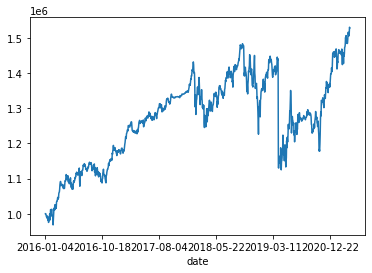

In [31]:
df_account_value.set_index('date').account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.105092
Cumulative returns     0.529126
Annual volatility      0.184847
Sharpe ratio           0.638680
Calmar ratio           0.434061
Stability              0.554263
Max drawdown          -0.242113
Omega ratio            1.152888
Sortino ratio          0.797683
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.039143
Daily value at risk   -0.022820
dtype: float64


In [39]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2016-01-04,NaN,2017-01-03
1,9.999796e+05,2016-01-05,-0.000020,2017-01-04
2,9.978065e+05,2016-01-06,-0.002173,2017-01-05
3,9.932461e+05,2016-01-07,-0.004570,2017-01-06
4,9.905973e+05,2016-01-08,-0.002667,2017-01-09
...,...,...,...,...
1066,1.509944e+06,2021-03-30,-0.004485,2021-03-30
1067,1.506310e+06,2021-03-31,-0.002406,2021-03-31
1068,1.511841e+06,2021-04-01,0.003672,2021-04-01
1069,1.531096e+06,2021-04-05,0.012736,2021-04-05


In [37]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-04-06'

<a id='6.2'></a>
## 7.2 BackTestPlot

In [38]:
print("==============Compare to DJIA===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1322, 8)


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2019-04-05 00:00:00+00:00', '2019-04-08 00:00:00+00:00',\n               '2019-04-09 00:00:00+00:00', '2019-04-10 00:00:00+00:00',\n               '2019-04-11 00:00:00+00:00',\n               ...\n               '2020-03-30 00:00:00+00:00', '2020-03-31 00:00:00+00:00',\n               '2020-04-01 00:00:00+00:00', '2020-04-02 00:00:00+00:00',\n               '2020-04-03 00:00:00+00:00'],\n              dtype='datetime64[ns, UTC]', name='date', length=252, freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

<a id='6.3'></a>
## 7.3 Baseline Stats

In [35]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1322, 8)
Annual return          0.136321
Cumulative returns     0.955059
Annual volatility      0.198830
Sharpe ratio           0.743460
Calmar ratio           0.367579
Stability              0.823306
Max drawdown          -0.370862
Omega ratio            1.175499
Sortino ratio          1.025462
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.888069
Daily value at risk   -0.024464
dtype: float64
